## General information

In this kernel I'm working with data from TMDB Box Office Prediction Challenge. Film industry is booming, the revunues are growing, so we have a lot of data about films. Can we build models, which will be able to accurately predict film revenues? Could this models be used to make some changes in movies to increase their revenues even further? I'll try answer this questions in my kernel!

![](https://i.imgur.com/KVb5zO7.jpg)
*(Screenshot of the main page of https://www.themoviedb.org/)*

## Content

* [1 Data loading and overview](#data_loading)
* [1.1 belongs_to_collection](#btoc)
* [1.2 genres](#genres)
* [1.3 Production companies](#production_companies)
* [1.4 Production countries](#production_countries)
* [1.5 Spoken languages](#lang)
* [1.6 Keywords](#keywords)
* [1.7 Cast](#cast)
* [1.8 Crew](#crew)
* [2 Data exploration](#de)
* [2.1 Target](#target)
* [2.2 Budget](#budget)
* [2.3 Homepage](#homepage)
* [2.4 Original language](#or_lang)
* [2.5 Original title](#or_title)
* [2.6 Overview](#overview)
* [2.7 Popularity](#popularity)
* [2.8 Release date](#release_date)
* [2.9 Runtime](#runtime)
* [2.10 Status](#status)
* [2.11 Tagline](#tagline)
* [2.12 Collections](#collections)
* [2.13 Genres](#genres_)
* [2.14 Production companies](#prod_comp)
* [2.15 Production countries](#prod_count)
* [2.16 Cast](#cast_viz)
* [2.17 Keywords](#key_viz)
* [2.18 Crew](#crew_viz)
* [3 Modelling and feature generation](#basic_model)
* [3.1 OOF features based on texts](#oof)
* [3.2 Additional feature generation](#add_feat)
* [3.3 Important features](#imp_feats)
* [3.4 External features](#ext_feats)
* [3.5 Blending](#blending)
* [3.6 Stacking](#stacking)

In [1]:
# Libraries

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
# nltk 自然語言處理工具包
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
# ELI5是一个Python包，它有助于调试机器学习分类器并解释它们的预测。
import eli5
# SHAP（SHapley Additive exPlanations）是一种统一的方法来解释任何机器学习模型的输出。
# SHAP将博弈论与局部解释联系起来，将几种先前的方法结合起来，并基于期望表示唯一可能的一致且局部准确的加性特征归因方法。
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

D:\python\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\python\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\python\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


<a id="data_loading"></a>
## Data loading and overview

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    3000 non-null object
budget                   3000 non-null int64
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords            

In [4]:
train.head()

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                 {}   3300000   
3   4                                                 {}   1200000   
4   5                                                 {}         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   
2  [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                 {}   
4                                                 {}   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...     10/10/14    105.0   
3            [{'iso_3166_1': 'IN', 'name': 'India'}]       3/9/12    122.0   
4      [{'iso_3166_1': 'KR', 'name': 'South Korea'}]       2/5/09    118.0   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
4           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name':

In [5]:
train.shape, test.shape

((3000, 23), (4398, 22))

There are only 3000 samples in train data! Let's hope this is enough to train models.

We can see that some of columns contain lists with dictionaries. Some lists contain a single dictionary, some have several. Let's extract data from these columns!

<a id="btoc"></a>
### belongs_to_collection

In [6]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [7]:
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

2396 values in this column are empty, 604 contrain information about the collections. I suppose that only collection name can be useful. Another possibly useful feature is the fact of belonging to a collection.

In [8]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

<a id="genres"></a>
### genres

In [9]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [10]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [11]:
for i, e in enumerate(train[train['genres'].str.len() == 7]['genres']):
    print(i, e)
    print('\n')

0 [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}, {'id': 878, 'name': 'Science Fiction'}]


1 [{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 878, 'name': 'Science Fiction'}, {'id': 10749, 'name': 'Romance'}, {'id': 10751, 'name': 'Family'}, {'id': 10769, 'name': 'Foreign'}]


2 [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}]




Genres column contains named and ids of genres to which films belong. Most of films have 2-3 genres and 5-6 genres are possible. 0 and 7 are outliers, I think. Let's extract genres! I'll create a column with all genres in the film and also separate columns for each genre.

But at first let's have a look at the genres themselves.

类型列包含电影所属类型的命名和ID。 大多数电影有2-3种类型，可能有5-6种类型。 我认为0和7是异常值。 让我们提取类型！ 我将在电影中创建一个包含所有类型的列，并为每个类型创建单独的列。

但首先让我们来看看这些类型。

In [12]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [13]:
list_of_genres[0:10]

[['Comedy'],
 ['Comedy', 'Drama', 'Family', 'Romance'],
 ['Drama'],
 ['Thriller', 'Drama'],
 ['Action', 'Thriller'],
 ['Animation', 'Adventure', 'Family'],
 ['Horror', 'Thriller'],
 ['Documentary'],
 ['Action', 'Comedy', 'Music', 'Family', 'Adventure'],
 ['Comedy', 'Music']]

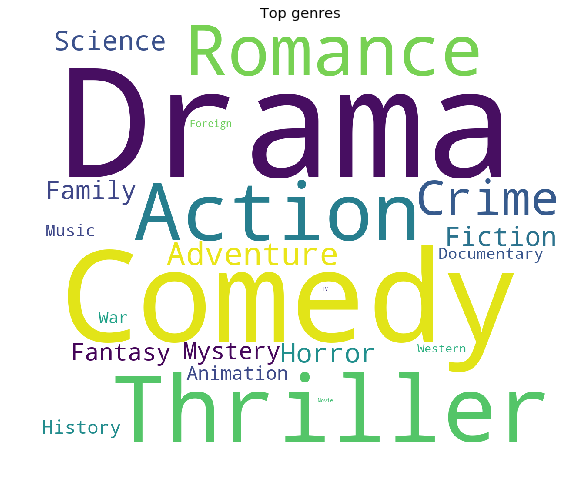

In [14]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])

# collocations ：bool，default = True 是否包括两个单词的搭配（双字母）。如果使用generate_from_frequencies则忽略。
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

Drama, Comedy and Thriller are popular genres.

Counter类的目的是用来跟踪值出现的次数。它是一个无序的容器类型，以字典的键值对形式存储，其中元素作为key，其计数作为value。计数值可以是任意的Interger（包括0和负数）。Counter类和其他语言的bags或multisets很相似。
    
    most_common：返回一个TopN列表。如果n没有被指定，则返回所有元素。当多个元素计数值相同时，排列是无确定顺序的。
    elements：返回一个迭代器。元素被重复了多少次，在该迭代器中就包含多少个该元素。元素排列无确定顺序，个数小于1的元素不被包含。

In [15]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

In [16]:
train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

0                                                Comedy
1                           Comedy Drama Family Romance
2                                                 Drama
3                                        Drama Thriller
4                                       Action Thriller
5                            Adventure Animation Family
6                                       Horror Thriller
7                                           Documentary
8                  Action Adventure Comedy Family Music
9                                          Comedy Music
10                                                Drama
11                                               Comedy
12                                                Drama
13                                         Comedy Crime
14              Action Mystery Science Fiction Thriller
15                                   Action Crime Drama
16                                      Horror Thriller
17                                        Drama 

I'll create separate columns for top-15 genres.

In [17]:
# 如果存在 genres 则保留其长度，否则长度设置为0
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
# sorted 会将 name 按照首字母进行排序，all_genres列保留电影所属的类别
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]

# 为各个类别创建一个特征，特征名为'genre_' + g
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

<a id="production_companies"></a>
### production_companies

In [18]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [19]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

Most of films have 1-2 production companies, cometimes 3-4. But there are films with 10+ companies! Let's have a look at some of them.

In [20]:
train[train['production_companies'].apply(lambda x: len(x) if x != {} else 0) > 11]

id    budget                                           homepage  \
31      32         0                        http://www.cache-derfilm.at   
116    117         0                                                NaN   
363    364  15400000                                                NaN   
392    393         0                                                NaN   
449    450  80000000             http://asoundofthunder.warnerbros.com/   
554    555  14500000                                                NaN   
1079  1080   7000000                                                NaN   
2170  2171   4000000  http://tickets.picturehouseentertainment.co.uk...   
2395  2396         0                                                NaN   
2517  2518  97250400  http://www.asterixauxjeuxolympiques.com/index.php   

        imdb_id original_language               original_title  \
31    tt0387898                fr                        Caché   
116   tt2113822                zh                         一九四二   
363   tt2053425                fr           De rouille et d'os   
392   tt5072406                fr                         Moka   
449   tt0318081                en           A Sound of Thunder   
554   tt0293416                ja                   Metropolis   
1079  tt2737050                fr         Deux jours, une nuit   
2170  tt3464902                en                  The Lobster   
2395  tt4082068                fr                      Dheepan   
2517  tt0463872                fr  Astérix aux Jeux Olympiques   

                                               overview  popularity  \
31    A married couple is terrorized by a series of ...    5.695860   
116   In 1942, Henan Province was devastated by the ...    1.678013   
363   Put in charge of his young son, Ali leaves Bel...    8.400049   
392   Diane Kramer is led by one obsession: to find ...    2.404466   
449   When a hunter sent back to the prehistoric era...    4.980191   
554   Duke Red has overseen the construction of a ma...    9.298092   
1079  Sandra is a young woman who has only one weeke...    6.868022   
2170  In a dystopian near future, single people, acc...   11.223033   
2395  Dheepan is a Sri Lankan Tamil warrior who flee...    5.752416   
2517  Ast√©rix and Ob√©lix have to win the Olympic G...    9.671944   

                           poster_path  \
31    /i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg   
116    /xxz2gi8vijqqJySGO3kQy2i8mv.jpg   
363   /cHCwW8xPl8yPKQwpNzKVinwvirT.jpg   
392   /5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg   
449   /gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg   
554   /1EK7mGCpRKYmSg25FaojvnS9opm.jpg   
1079  /1mYAejpMskvskGr0J0SaBvdjmrH.jpg   
2170  /yR60EqMGS9hHq9I5Pkq2hG984TP.jpg   
2395  /lgONuekbRlM0eMvMHJBEDL6MsBP.jpg   
2517  /tKL0RJOeuccc1rrpcDKg8qhedIz.jpg   

                                   production_companies  \
31    [{'name': 'Les Films du Losange', 'id': 223}, ...   
116   [{'name': 'Emperor Motion Pictures', 'id': 272...   
363   [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
392   [{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...   
449   [{'name': 'Epsilon Motion Pictures', 'id': 117...   
554   [{'name': 'Bandai Visual Company', 'id': 528},...   
1079  [{'name': 'BIM Distribuzione', 'id': 225}, {'n...   
2170  [{'name': 'Haut et Court', 'id': 726}, {'name'...   
2395  [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
2517  [{'name': 'Constantin Film', 'id': 47}, {'name...   

                                   production_countries release_date  runtime  \
31    [{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...       5/2/05    117.0   
116             [{'iso_3166_1': 'CN', 'name': 'China'}]      11/1/12    145.0   
363   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      5/17/12    123.0   
392   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      8/17/16     89.0   
449   [{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...      5/15/05    110.0   
554             [{'iso_3166_1': 'JP', 'name': 'Japan'}]      5/26/01    10

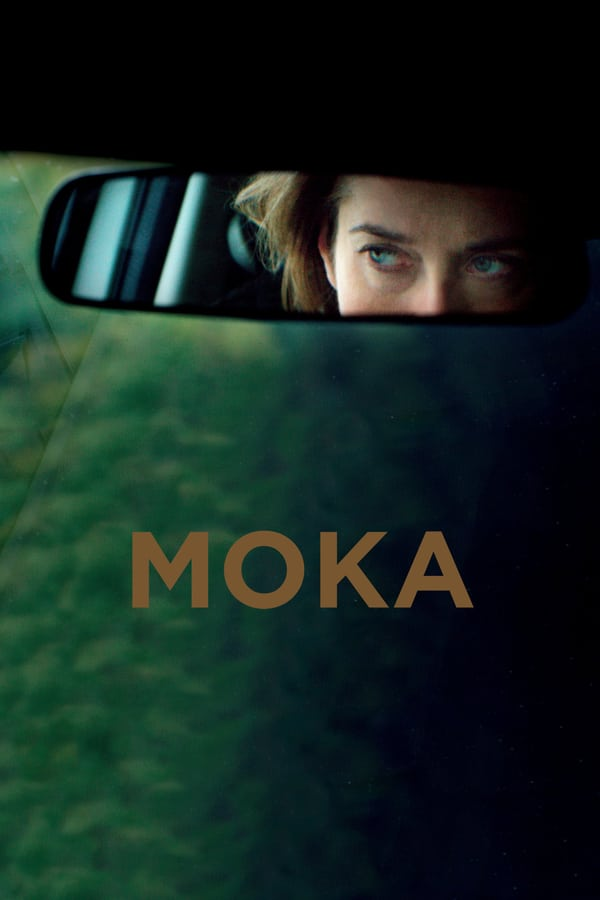

In [21]:
# example of poster of such a film

img = Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg"))
img

In [22]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [23]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

For now I'm not sure what to do with this data. I'll simply create binary columns for top-30 films. Maybe later I'll have a better idea.

In [24]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

In [25]:
train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...     10/10/14    105.0   
3            [{'iso_3166_1': 'IN', 'name': 'India'}]       3/9/12    122.0   
4      [{'iso_3166_1': 'KR', 'name': 'South Korea'}]       2/5/09    118.0   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
4           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                 {}   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000   
3  [{'credit_id': '52fe48779251416c9108d6eb', 'de...  16000000   
4  [{'credit_id': '52fe464b9251416c75073b43', 'de...   3923970   

                   c

<a id="production_countries"></a>
### production_countries

In [26]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [27]:
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

Normally films are produced by a single country, but there are cases when companies from several countries worked together.

In [28]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

画词云图

In [29]:
# list_of_companies1=list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []))
# text=' '.join(['_'.join(i.split(' ')) for j in list_of_companies1 for i in j])
# fig=plt.figure(figsize=(15,12))
# wordcloud=WordCloud(max_font_size=None,background_color='black',width=2100,height=2200,collocations=False).generate(text)
# plt.imshow(wordcloud)
# plt.title('Top production_countries')
# plt.axis("off")
# plt.show()

In [30]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

<a id="lang"></a>
### Spoken languages

In [31]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [32]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [33]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [34]:
# list_of_companies1=list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []))
# text=' '.join(['_'.join(i.split(' ')) for j in list_of_languages for i in j])
# fig=plt.figure(figsize=(15,12))
# wordcloud=WordCloud(max_font_size=None,background_color='black',width=1100,height=1200,collocations=False).generate(text)
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.imshow(wordcloud)
# plt.title('Top spoken_languages')
# plt.axis("off")
# plt.show()

In [35]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

<a id="keywords"></a>
### Keywords

In [36]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [37]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

Here we have some keywords describing films. Of course there can be a lot of them. Let's have a look at the most common ones.

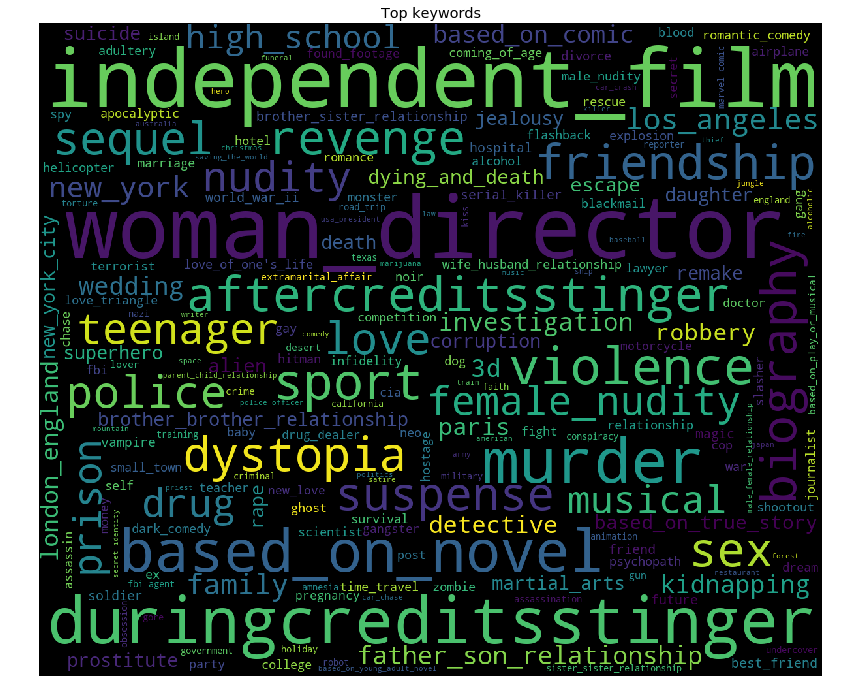

In [38]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

In [39]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

In [40]:
train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime    status  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000   
3  [{'credit_id': '52fe48779251416c9108d6eb', 'de...  16000000   
4  [{'credit_id': '52fe464b9251416c75073b43', 'de...   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                                0               0           2   

                    all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
0                       Comedy            0             1               0   
1  Comedy Drama Family Romance            1             1               0   
2                        Drama            1             0               0   
3               Drama Thriller            1             0               1   
4              Action Thriller            0             0               1   

   genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0             0              0            0                0             0   
1             0

<a id="cast"></a>
### cast

In [41]:
for i, e in enumerate(train['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [42]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

Those who are casted heavily impact the quality of the film. We have not only the name of the actor, but also the gender and character name/type.

At first let's have a look at the popular names.

In [43]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

拿 cast 们的照片

In [44]:
# list_of_cast_names_url = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
# d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
# fig = plt.figure(figsize=(20, 12))
# for i, p in enumerate([j[0] for j in d]):
#     ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
#     im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
#     plt.imshow(im)
#     ax.set_title(f'{p[0]}')

In [45]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

0 is unspecified, 1 is female, and 2 is male. (https://www.kaggle.com/c/tmdb-box-office-prediction/discussion/80983#475572)

0未指定，1为女性，2为男性

In [46]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

I think it is quite funny the most popular male role is playing himself. :)

In [47]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
# 每个样本中 cast 里的演员的不同性别的数量
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

In [48]:
train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime    status  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000   
3  [{'credit_id': '52fe48779251416c9108d6eb', 'de...  16000000   
4  [{'credit_id': '52fe464b9251416c75073b43', 'de...   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                                0               0           2   

                    all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
0                       Comedy            0             1               0   
1  Comedy Drama Family Romance            1             1               0   
2                        Drama            1             0               0   
3               Drama Thriller            1             0               1   
4              Action Thriller            0             0               1   

   genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0             0              0            0                0             0   
1             0              1            0                0             0   
2             0              0            0                0             0   
3             0              0            0                0             0   
4             1              0            0                0             0   

   genre_Science Fiction  genre_Family 

<a id="crew"></a>
### crew

In [49]:
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [50]:
print('Number of casted persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

The great crew is very important in creating the film. We have not only the names of the crew members, but also the genders, jobs and departments.

At first let's have a look at the popular names.

伟大的工作人员在制作电影时非常重要。 我们不仅有船员的名字，还有性别，工作和部门。

首先让我们来看看流行的名字。

In [51]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [52]:
# list_of_crew_names_url = list(train['crew'].apply(lambda x: [(i['name'], i['profile_path'], i['job']) for i in x] if x != {} else []).values)
# d = Counter([i for j in list_of_crew_names_url for i in j]).most_common(16)
# fig = plt.figure(figsize=(20, 16))
# for i, p in enumerate([j[0] for j in d]):
#     ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
#     if p[1]:
#         im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
#     else:
#         im = Image.new('RGB', (5, 5))
#     plt.imshow(im)
#     ax.set_title(f'Name: {p[0]} \n Job: {p[2]}')

In [53]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [54]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(3)

[(0, 41787), (2, 24898), (1, 6412)]

In [55]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [56]:
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [57]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

<a id="de"></a>
## Data exploration

In [58]:
train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime    status  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title   revenue  \
0                    Hot Tub Time Machine 2  12314651   
1  The Princess Diaries 2: Royal Engagement  95149435   
2                                  Whiplash  13092000   
3                                   Kahaani  16000000   
4                                Marine Boy   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                                0               0           2   

                    all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
0                       Comedy            0             1               0   
1  Comedy Drama Family Romance            1             1               0   
2                        Drama            1             0               0   
3               Drama Thriller            1             0               1   
4              Action Thriller            0             0               1   

   genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0             0              0            0                0             0   
1             0              1            0                0             0   
2             0              0            0                0             0   
3             0              0            0                0             0   
4             1              0            0                0             0   

   genre_Science Fiction  genre_Family  genre_Fantasy  genre_Mystery  \
0                      0             0              0              0   
1                      0             1              0              0   
2                      0             0              0              0   
3                      0             0              0              0   
4               

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 233 entries, id to departments_Actors
dtypes: float64(2), int64(219), object(12)
memory usage: 5.3+ MB


In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Columns: 232 entries, id to departments_Actors
dtypes: float64(2), int64(218), object(12)
memory usage: 7.8+ MB


<a id="target"></a>
### Target

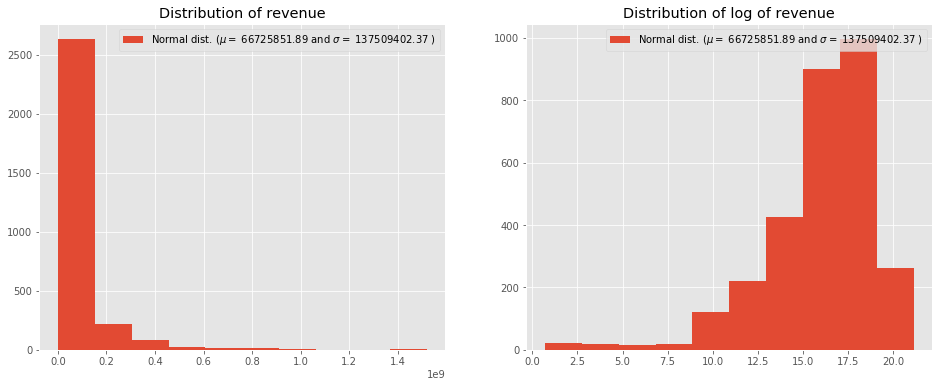

In [61]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);

(mu,sigma)=stats.norm.fit(train['revenue'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.title('Distribution of revenue');

plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');
(mu,sigma)=stats.norm.fit(train['revenue'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')

查看收入的偏度和峰度

In [62]:
print('未对数化前 偏度为 %s 峰度为 %s \n '%(train['revenue'].skew(),train['revenue'].kurt()))
print('对数化后 偏度为 %s 峰度为 %s \n '%(np.log1p(train['revenue'].skew()),np.log1p(train['revenue'].kurt())))

未对数化前 偏度为 4.542285301660683 峰度为 27.78254883576798 
 
对数化后 偏度为 1.7124069250256446 峰度为 3.3597692602816225 
 


绘制QQ图

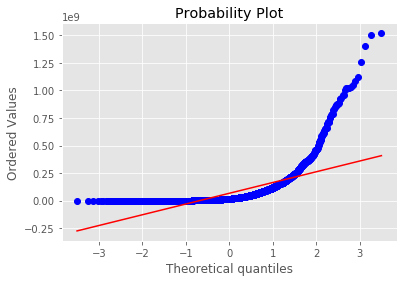

In [63]:
plt.figure()
stats.probplot(train['revenue'],plot=plt)
plt.show()

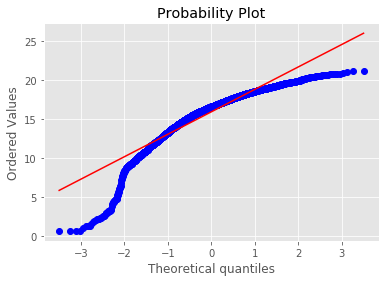

In [64]:
plt.figure()
stats.probplot(np.log1p(train['revenue']),plot=plt)
plt.show()

In [65]:
train['log_revenue'] = np.log1p(train['revenue'])

As we can see revenue distribution has a high skewness! It is better to use `np.log1p` of revenue.

我们可以看到收入分配有很高的偏差！ 最好使用np.log1p的收入。

<a id="budget"></a>
### Budget

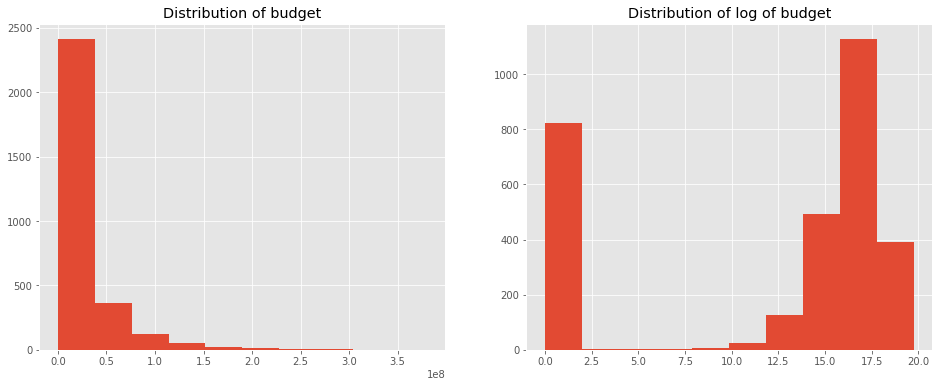

In [66]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

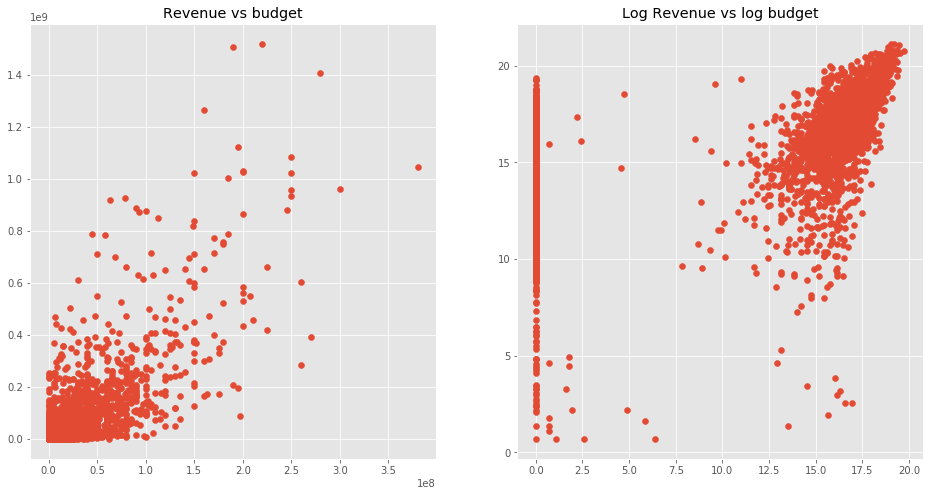

In [67]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

We can see that budget and revenue are somewhat correlated. Logarithm transformation makes budget distribution more managable.

我们可以看到预算和收入有些相关。 对数转换使预算分配更易于管理。

In [68]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

<a id="homepage"></a>
### homepage

In [69]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/                  4
http://www.lordoftherings.net/                     2
http://www.thehobbit.com/                          2
http://www.anjaanaanjaani.erosentertainment.com    1
http://wearethecircle.com/                         1
Name: homepage, dtype: int64

Most of homepages are unique, so this feature may be useless.

大多数主页都是独一无二的，因此这个功能可能毫无用处。

In [70]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

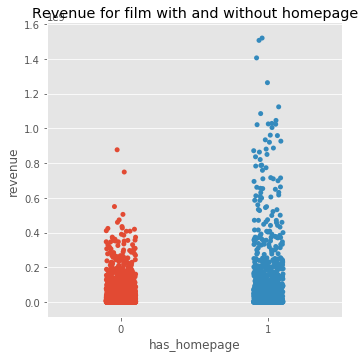

In [71]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

Films with homepage tend to generate more revenue! I suppose people can know more about the film thanks to homepage.

有主页的电影往往会产生更多收入！ 我想人们可以通过主页了解更多关于这部电影的信息。

<a id="or_lang"></a>
### original_language

`df.isin` 表示DataFrame中的每个元素是否都包含在值中 
    
    train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]
    选取排名前10的语言作为主语言，取出电影使用的语言为前10中语言的电影内容

In [72]:
train['revenue'].head(1)

0    12314651
Name: revenue, dtype: int64

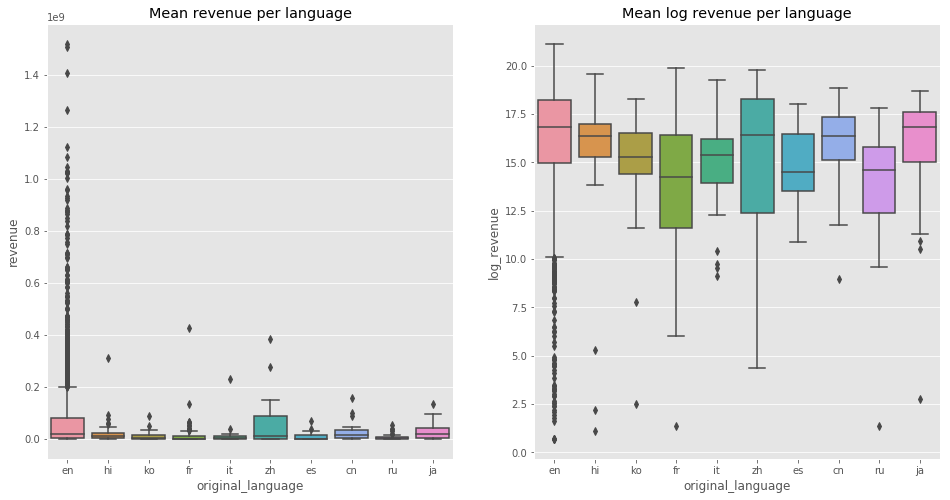

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

As we know there are much more english films and they have a higher range of values. Films with the highest revenue are usually in English, but there are also high revenue films in other languages.

我们知道有更多的英国电影，他们有更高的价值范围。 收入最高的电影通常使用英语，但也有其他语言的高收入电影。

<a id="or_title"></a>
### original_title

It can be interesting to see which words are common in titles.

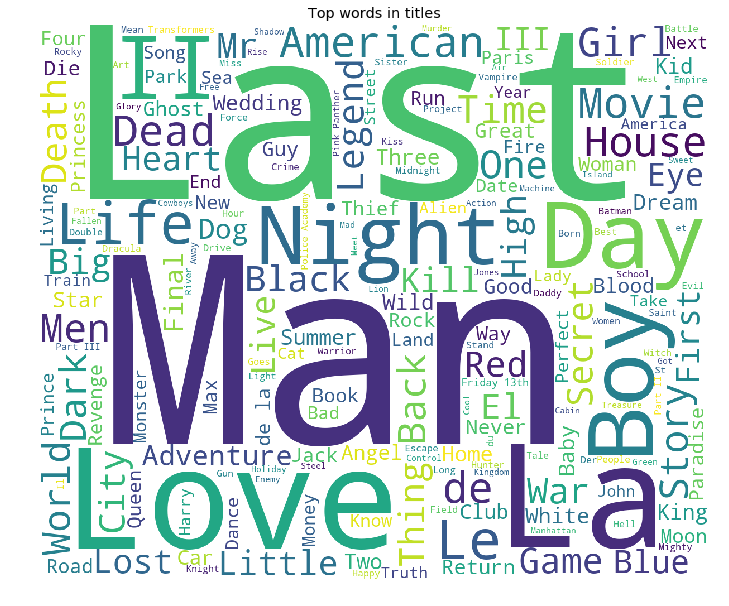

In [74]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

<a id="overview"></a>
### overview

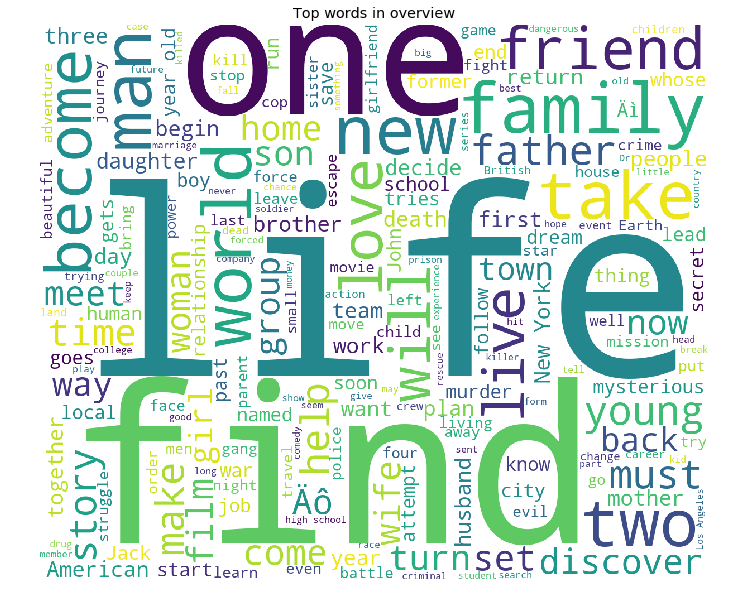

In [75]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()


    
__TfidfVectorizer参数介绍：__
    
*    __sublinear_tf：__ boolean， optional

    应用线性缩放TF，例如，使用1+log(tf)覆盖tf


*    __ngram_range(min,max)：__ tuple(min_n, max_n)
        
    是指将text分成min，min+1，min+2,.........max 个不同的词组
    
    比如'Python is useful'中ngram_range(1,3)之后可得到'Python'  'is'  'useful'  'Python is'  'is useful' 和'Python is               useful'如果是ngram_range (1,1) 则只能得到单个单词'Python'  'is'和'useful'


*    __token_pattern：__ string
        
    正则表达式显示了”token“的构成，仅当analyzer == ‘word’时才被使用。两个或多个字母数字字符的正则表达式（标点符号完全被忽略，始终被视为一个标记分隔符）。


*    __min_df：__ float in range [0.0, 1.0] or int, optional, 1.0 by default
        
    当构建词汇表时，严格忽略高于给出阈值的文档频率的词条，语料指定的停用词。如果是浮点值，该参数代表文档的比例，整型绝对计数值，如果词汇表不为None，此参数被忽略。


*    __analyzer：__ string，{'word', 'char'} or callable
        
    定义特征为词（word）或n-gram字符，如果传递给它的调用被用于抽取未处理输入源文件的特征序列

Let's try to see which words have high impact on the revenue. I'll build a simple model and use ELI5 for this.

让我们试着看看哪些词对收入有很大的影响。 我将构建一个简单的模型并使用ELI5。


In [76]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5,
            stop_words=stop)
 
overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

查看语句中 哪些特征词是重要的 哪些是不重要的

In [77]:
print('Target value:', train['log_revenue'][1001])
eli5.show_prediction(linreg, doc=train['overview'].values[1001], vec=vectorizer)

Target value: 17.55484547933661


We can see that some words can be used to predict revenue, but we will need more that overview text to build a good model.

我们可以看到一些单词可用于预测收入，但我们需要更多的概述文本来构建一个好的模型。

<a id="popularity"></a>
### popularity

I'm not exactly sure what does popularity represents. Maybe it is some king of weighted rating, maybe something else. It seems it has low correlation with the target.

我不确定人气代表什么。 也许它是加权评级的王者，也许是别的东西。 它似乎与目标的相关性较低。

Text(0.5, 0, 'popularity')

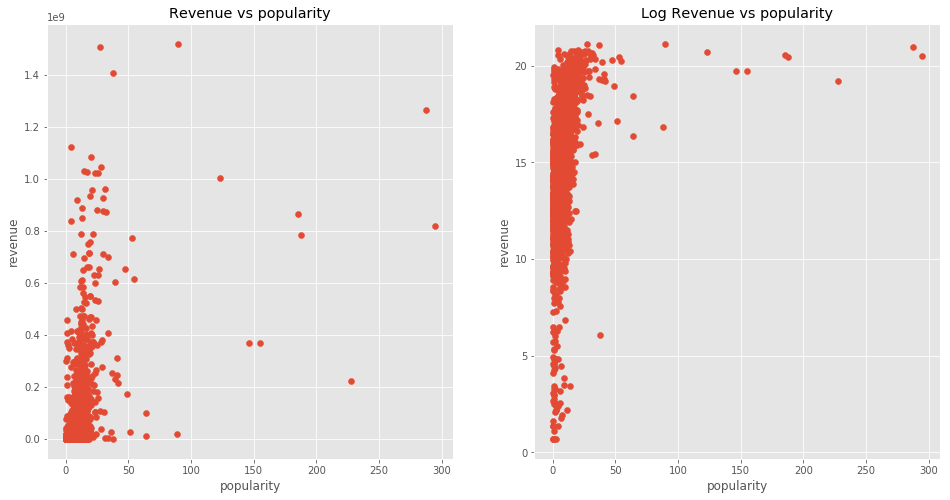

In [78]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.ylabel('revenue')
plt.xlabel('popularity')
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'])
plt.title('Log Revenue vs popularity');
plt.ylabel('revenue')
plt.xlabel('popularity')

<a id="release_data"></a>
### release_date

In [79]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

将日期时间转为 年/ 月/日 如 2015-02-20

In [80]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    x=str(x)
    try:
        year = x.split('/')[2]
    except Exception as e:
        year = x.split('-')[2]
        
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [81]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
# 将日期转为 datetime 类型
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [82]:
train['release_date'].dt.weekday.head()

0    4
1    4
2    4
3    4
4    3
Name: release_date, dtype: int64

In [83]:
getattr(train['release_date'].dt, 'year').head()

0    2015
1    2004
2    2014
3    2012
4    2009
Name: release_date, dtype: int64

In [84]:
train['release_date'].dt

In [85]:
# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        # 将 datetime 转成 DatetimeProperties 格式，然后提取里面的 年份 周 月...
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)

    return df

train = process_date(train)
test = process_date(test)

查看每年拍的电影数量

In [86]:
d1 = train['release_date_year'].value_counts()
d1.sort_index()

1921      1
1924      1
1925      2
1926      1
1927      2
1928      3
1930      1
1931      2
1932      3
1933      2
1935      1
1936      4
1938      1
1939      4
1940      2
1942      3
1943      2
1944      2
1945      4
1947      2
1948      6
1949      2
1950      2
1951      4
1952      1
1953      6
1954      6
1955      7
1956      4
1957      3
       ... 
1988     56
1989     47
1990     46
1991     42
1992     45
1993     56
1994     51
1995     62
1996     55
1997     63
1998     66
1999     65
2000     65
2001     77
2002     84
2003     74
2004     83
2005     99
2006    114
2007    105
2008    101
2009    106
2010    126
2011    124
2012    125
2013    141
2014    123
2015    128
2016    125
2017     40
Name: release_date_year, Length: 90, dtype: int64

In [87]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

每年 拍的电影数量 和 总收入

In [88]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()
d3 = train.groupby(['release_date_year'])['revenue'].mean()
# go.Scatter 根据数据进行绘制图线，顺序和代表的图例一一对应
data = [go.Scatter (x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
#  yaxis='y2' 对应下面的 yaxis2 (固定写法)
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  # overlaying 表示是否覆盖，不指定则只会绘制后面的线条
                  yaxis2 = dict(title='Total revenue', overlaying='y', side='right'),

                  ),
                  # orientation 指定图例放置的位置，v为右侧，h为下侧
                  legend=dict(orientation="h"))
py.iplot(dict(data=data, layout=layout))

In [89]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

We can see that number of films and total revenue are growing, which is to be expected. But there were some years in the past with a high number of successful films, which brought high revenue.

我们可以看到电影数量和总收入正在增长，这是可以预期的。 但过去几年有大量成功的电影，带来了高额收入。

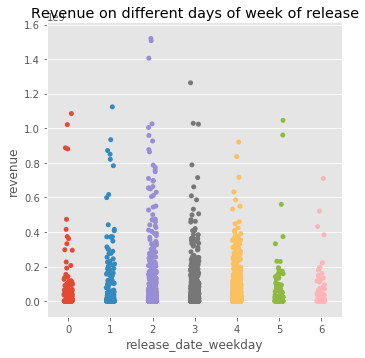

In [90]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

Surprisingly films releases on Wednesdays and on Thursdays tend to have a higher revenue.

令人惊讶的是，周三和周四的电影发行往往会有更高的收入。

<a id="runtime"></a>
### runtime

The length of the film in minutes

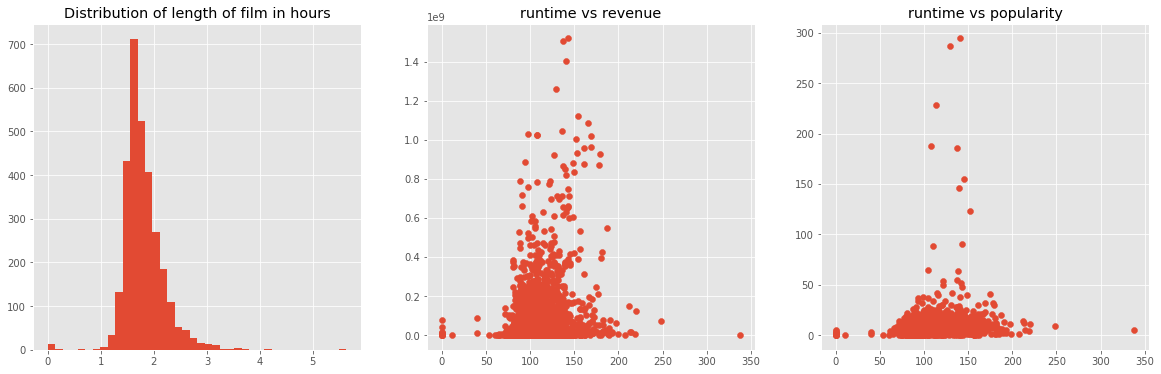

In [91]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range

似乎大多数电影的长度为1.5-2小时，收入最高的电影也在这个范围内

<a id="status"></a>
### Status

In [92]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [93]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

AS we can see only 4 films in train data and 7 in test aren't released yet, so this feature is quite useless.

我们只能看到训练数据中的4部电影和测试中的7部电影尚未发布，因此这个功能毫无用处

<a id="tagline"></a>
### tagline 标语

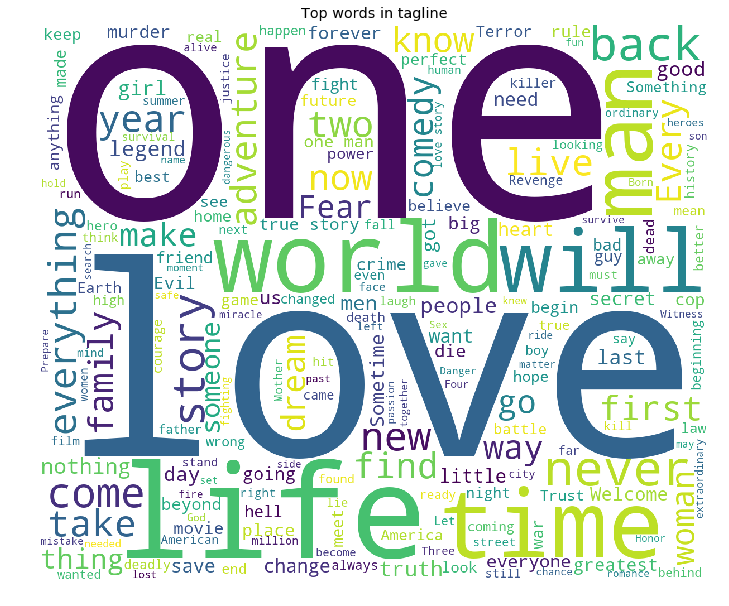

In [94]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

<a id="collections"></a>
### Collections  收藏

In [95]:
pd.unique(train['has_collection'])

array([1, 0], dtype=int64)

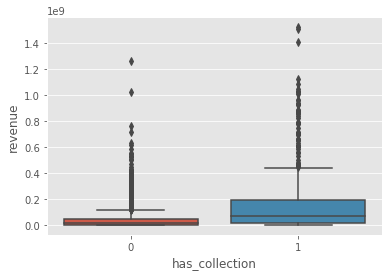

In [96]:
sns.boxplot(x='has_collection', y='revenue', data=train);

Films, which are part of a collection usually have higher revenues. I suppose such films have a bigger fan base thanks to previous films.

电影作为收藏品的一部分通常会有更高的收入。 我想这些电影由于以前的电影而拥有更大的粉丝基础。

<a id="genres_"></a>
### Genres 类型

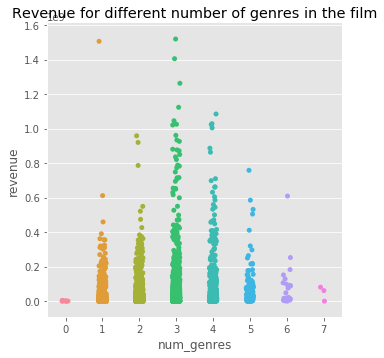

In [97]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

查看电影类型为 Drama 和不是 Drama 的电影的收入情况

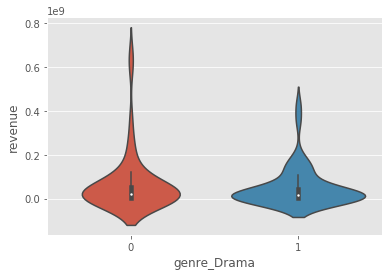

In [98]:
sns.violinplot(x='genre_Drama', y='revenue', data=train[:100]);

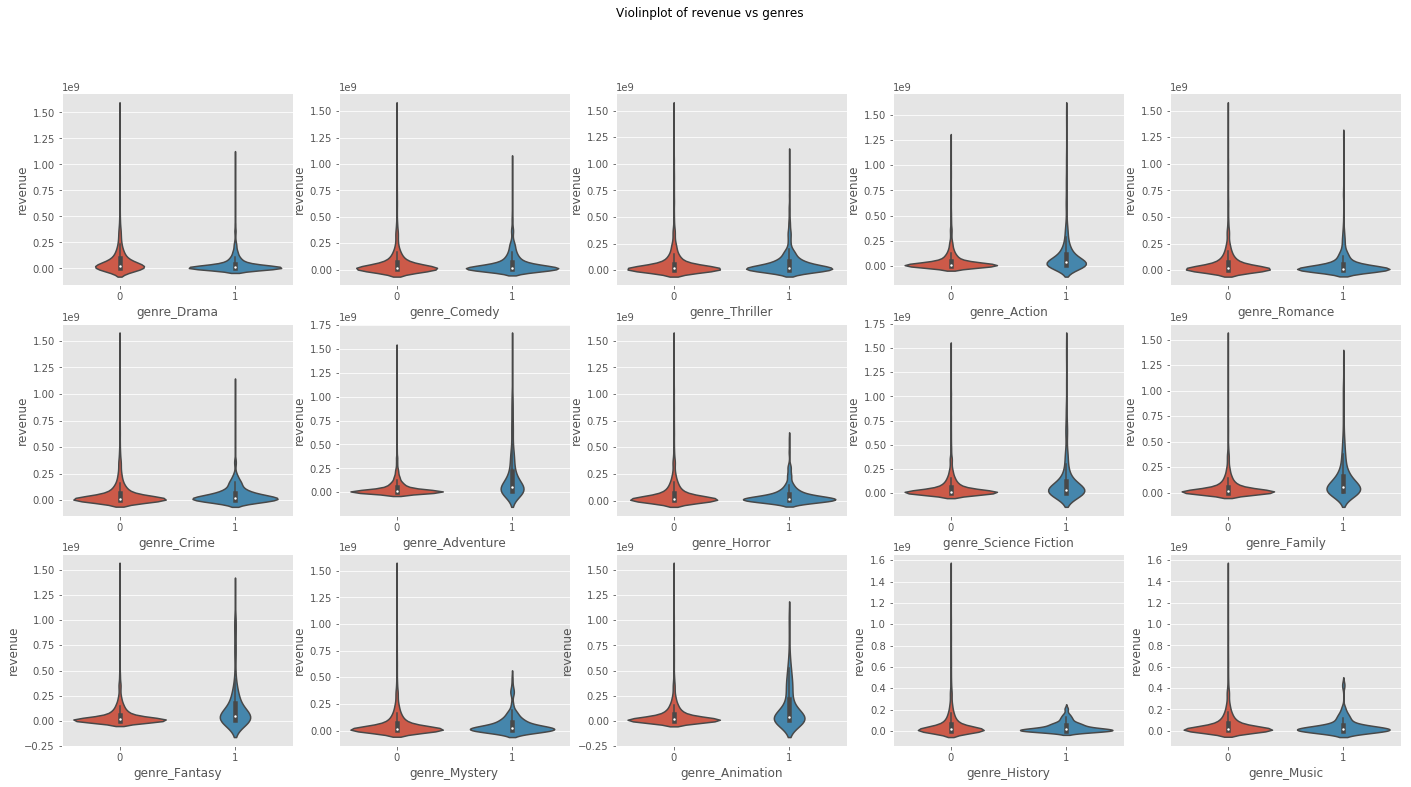

In [99]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    # % 取余，如果 i 比 5 小，那么余数就是他自己
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

Some genres tend to have less revenue, some tend to have higher.



有些类型往往收入较少，有些则往往较高。

<a id="prod_comp"></a>
### Production companies

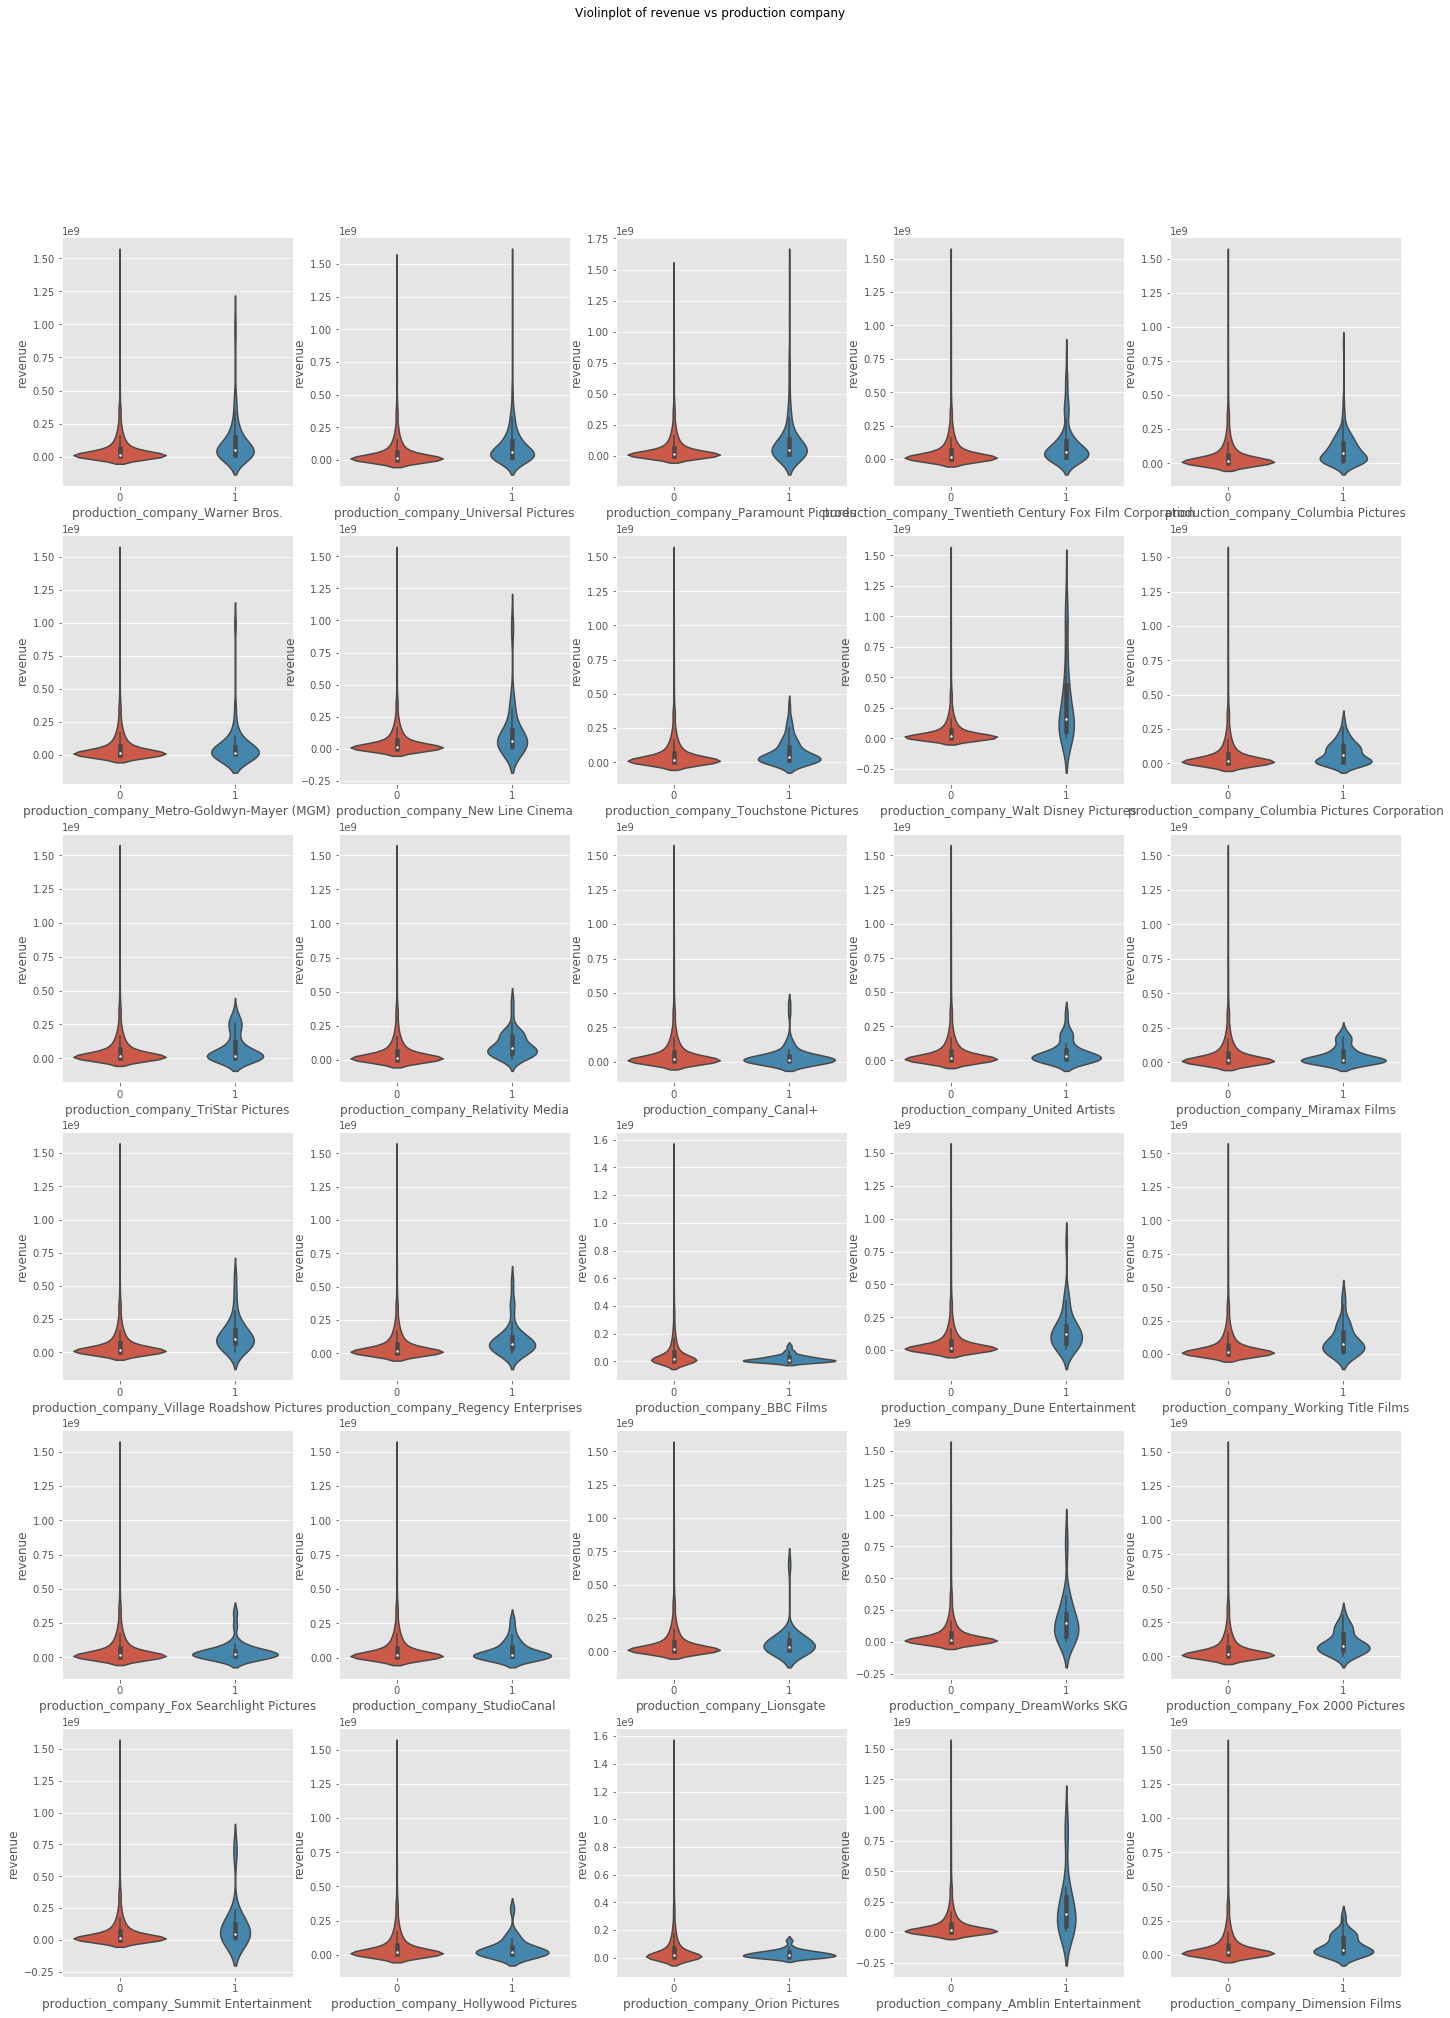

In [100]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

There are only a couple of companies, which have distinctly higher revenues compared to others.

只有几家公司的收入明显高于其他公司。

<a id="prod_count"></a>
### Production countries

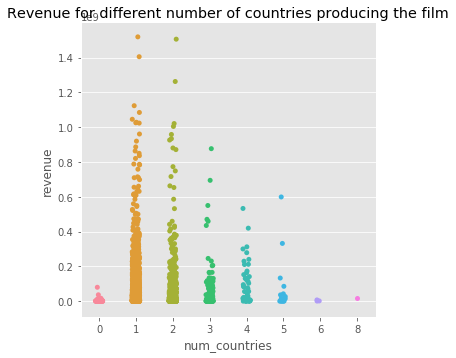

In [101]:
sns.catplot(x='num_countries', y='revenue', data=train);
plt.title('Revenue for different number of countries producing the film');

In fact I think that number of production countries hardly matters. Most films are produced by 1-2 companies, so films with 1-2 companies have the highest revenue.

事实上，我认为生产国的数量并不重要。 大多数电影由1-2家公司制作，因此拥有1-2家公司的电影收入最高。

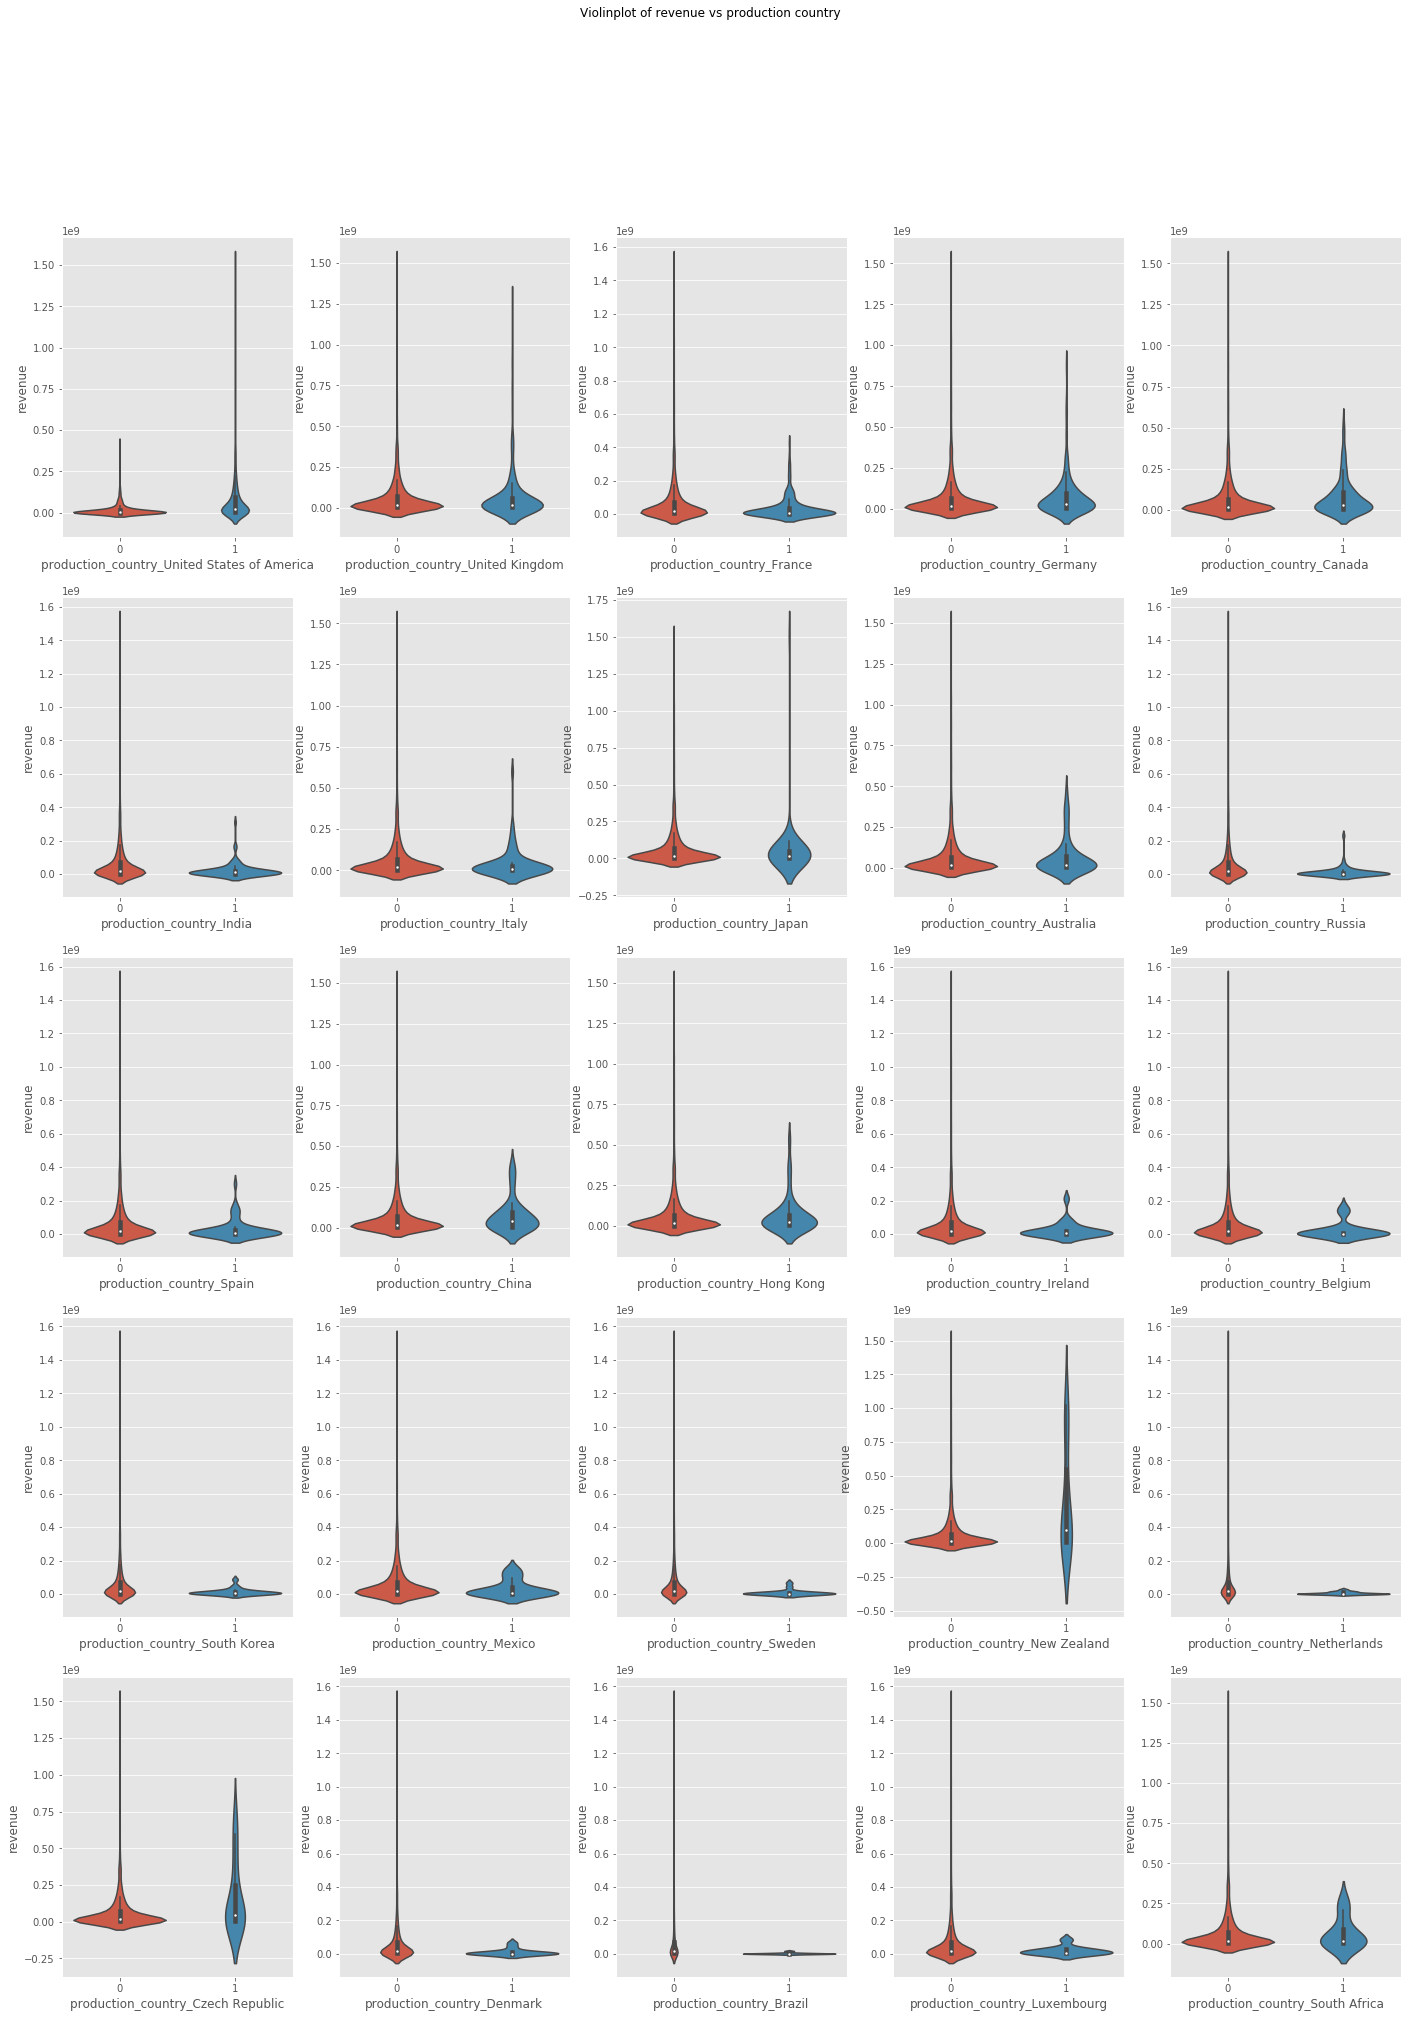

In [102]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

There are only a couple of countries, which have distinctly higher revenues compared to others.

只有几个国家的收入明显高于其他国家。

<a id="cast_viz"></a>
### Cast

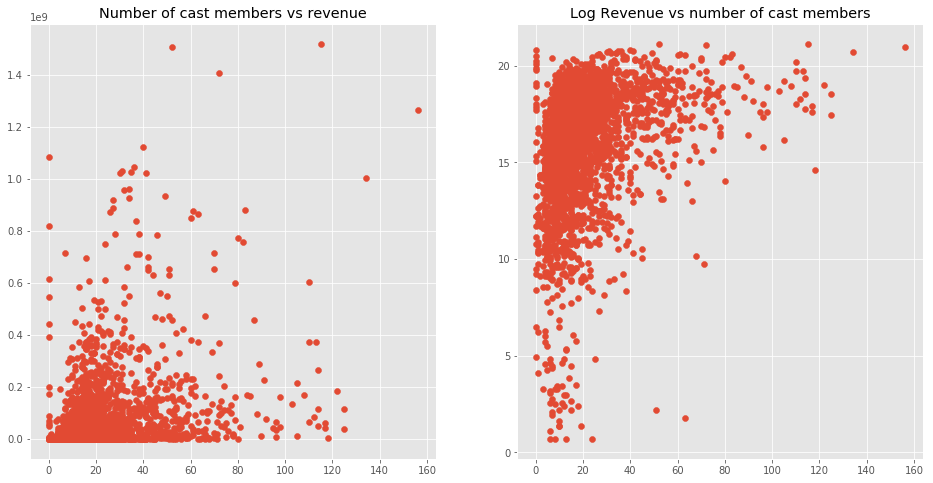

In [103]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Log Revenue vs number of cast members');

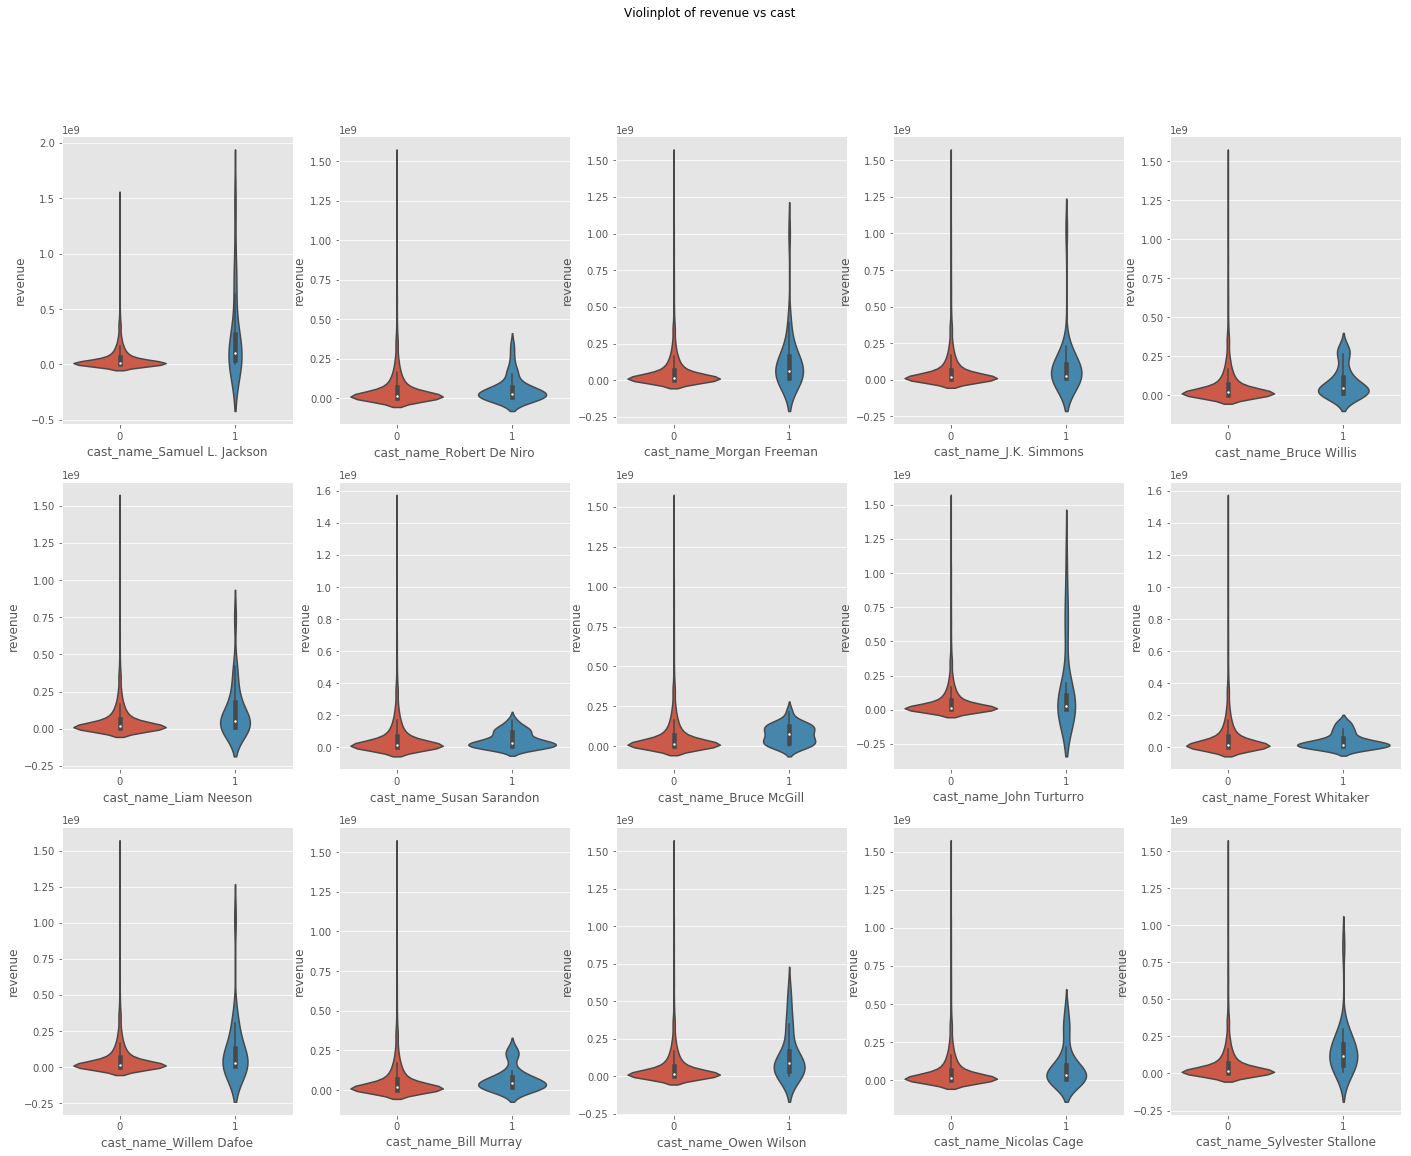

In [104]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

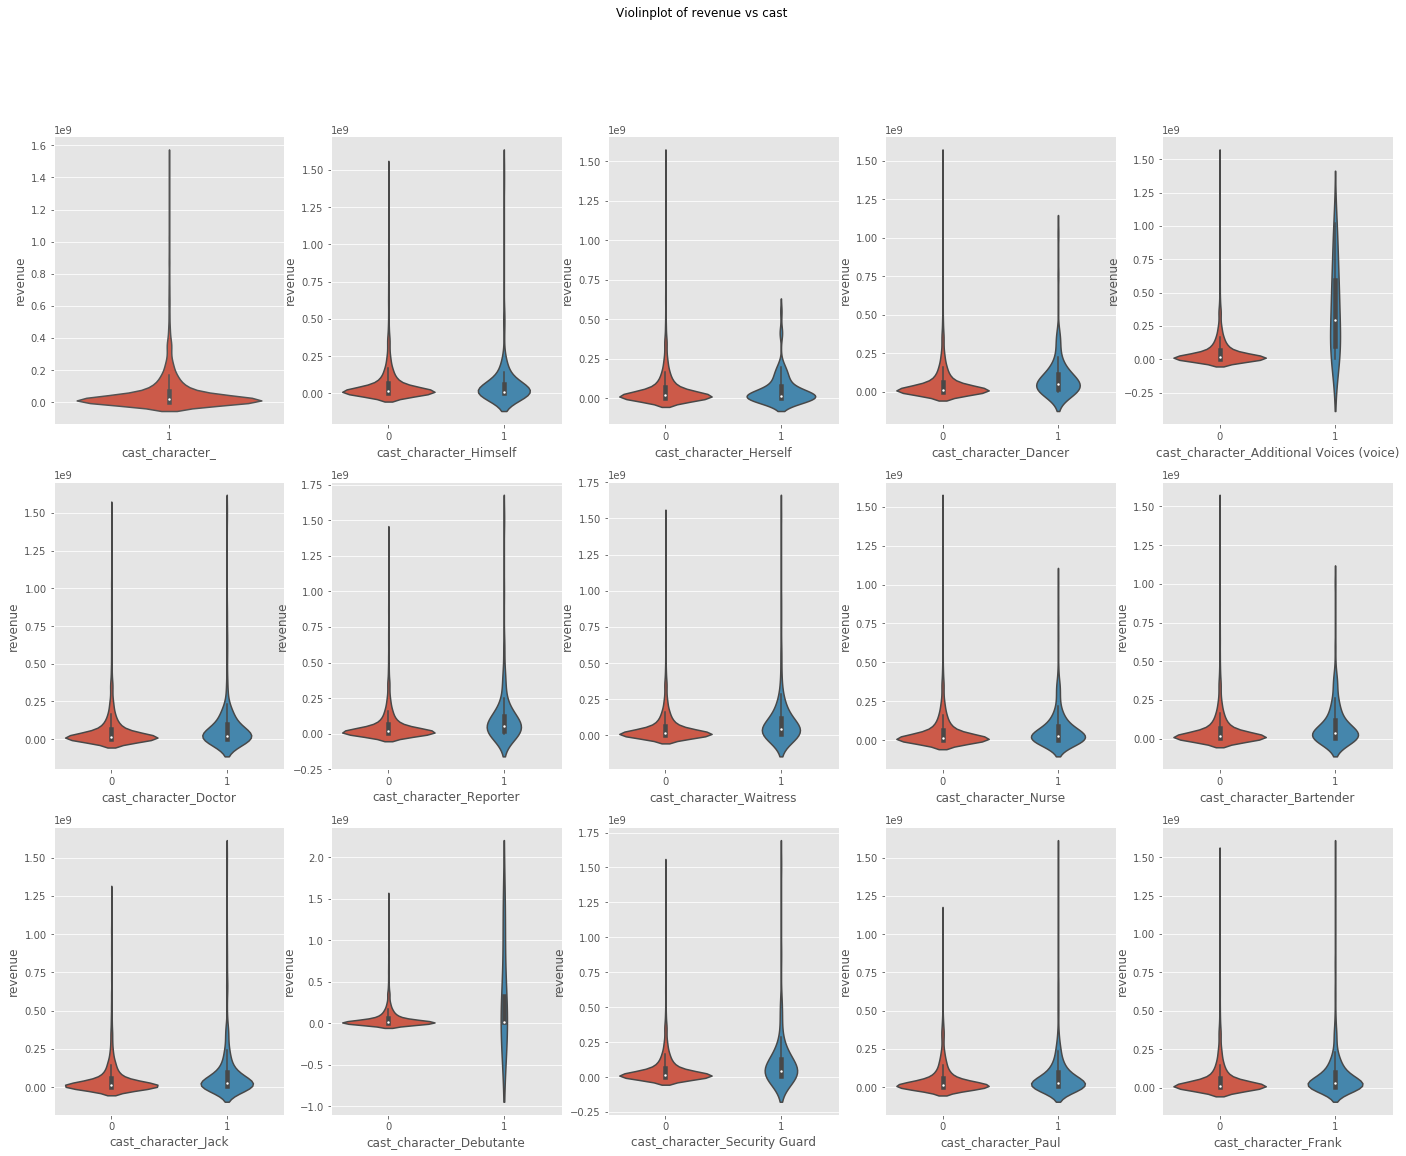

In [105]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="key_viz"></a>
### Keywords

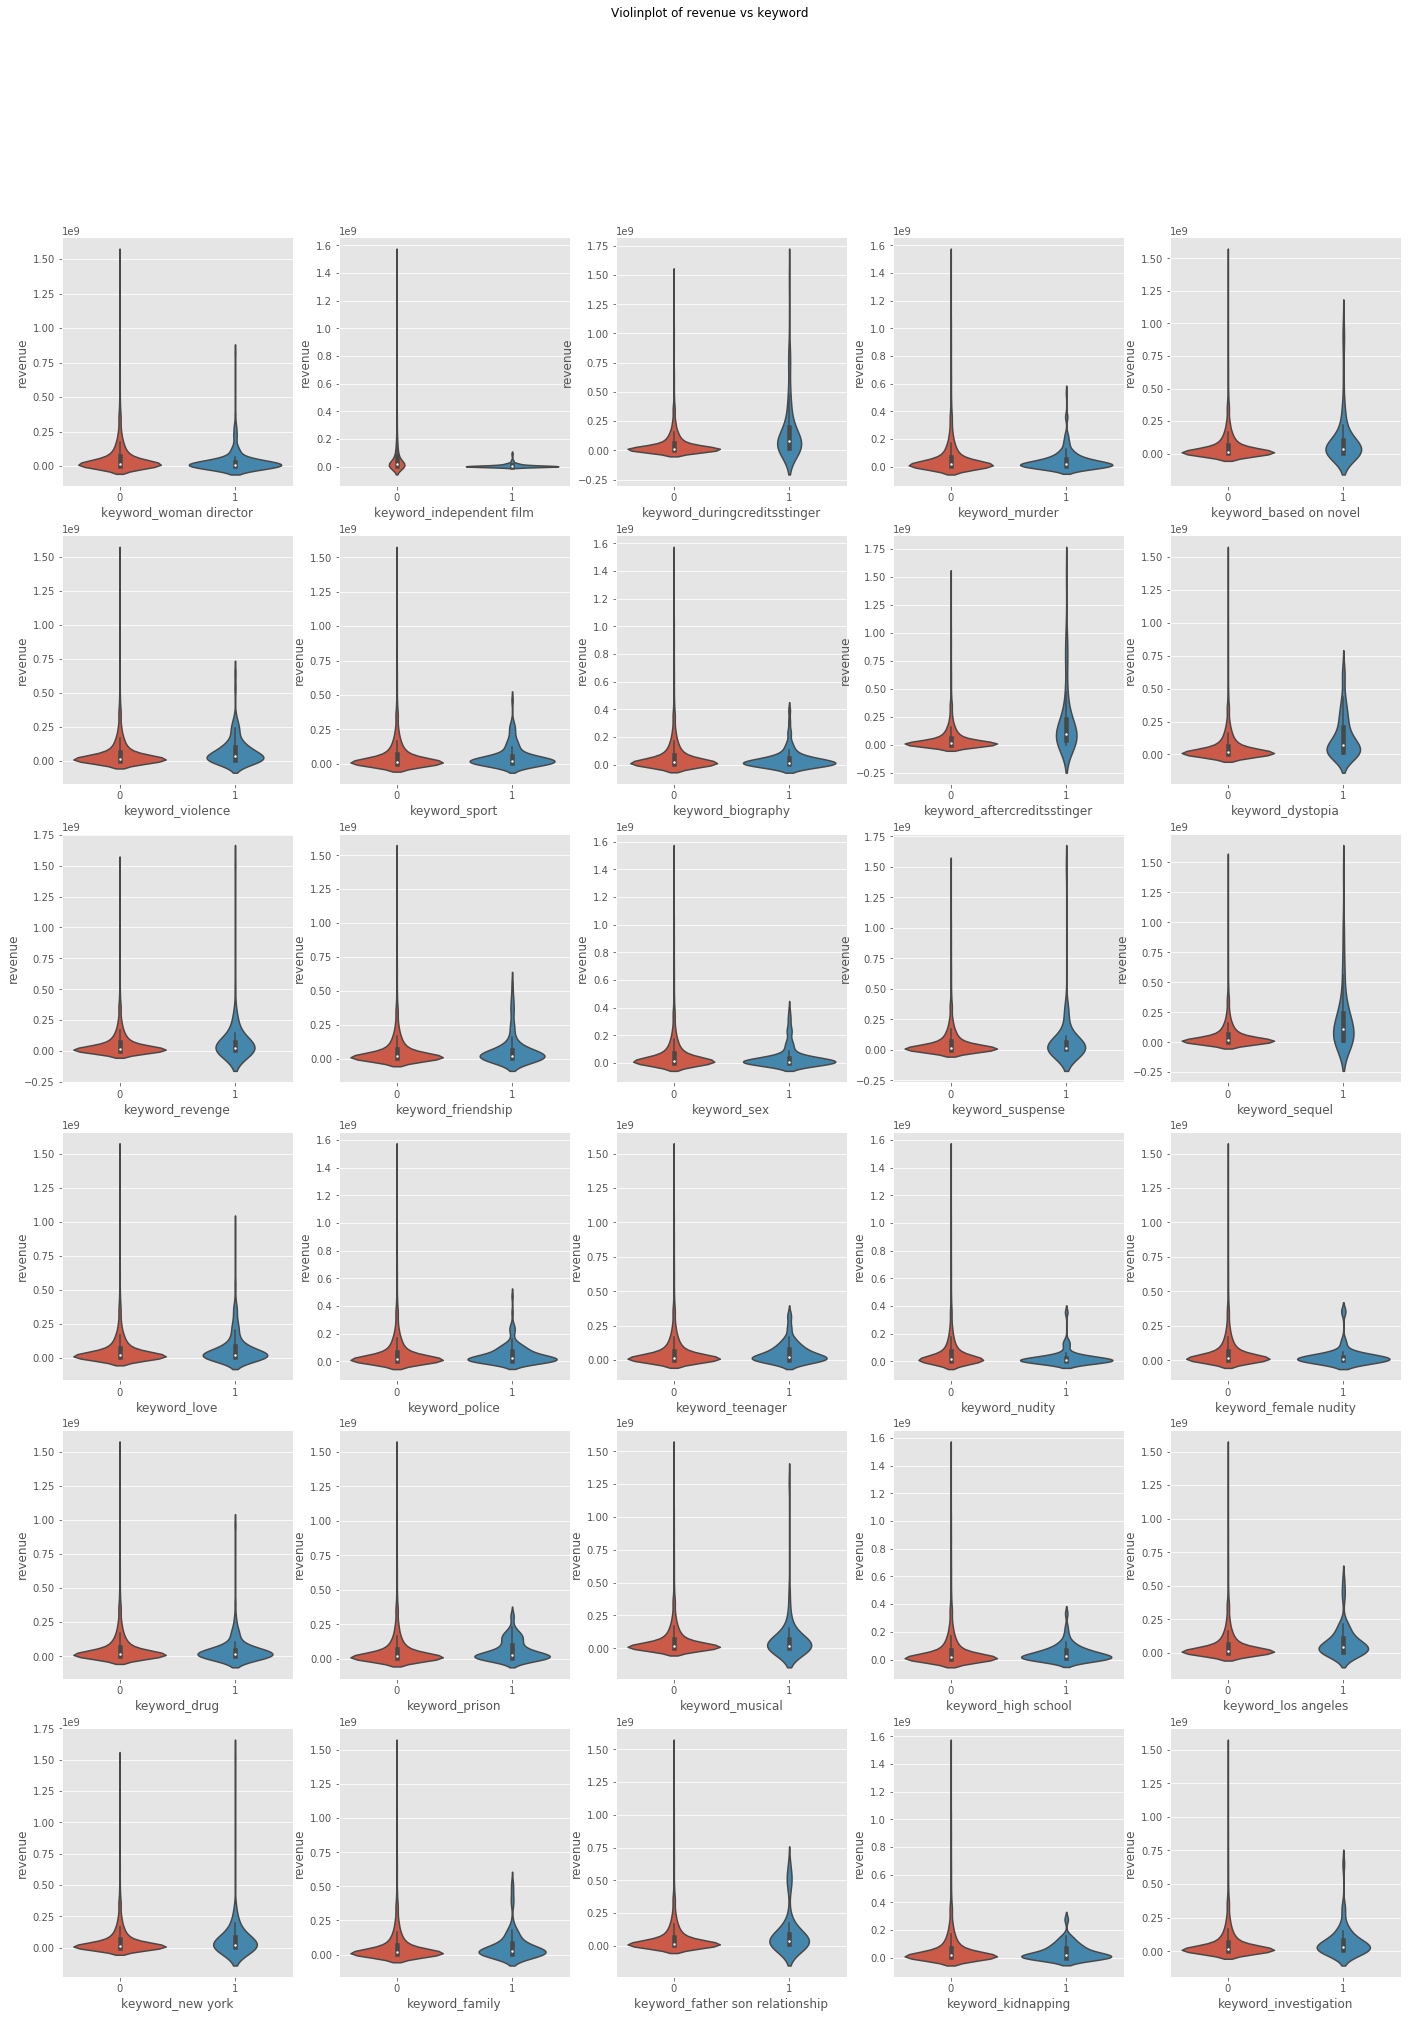

In [106]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="crew_viz"></a>
### Crew 人员

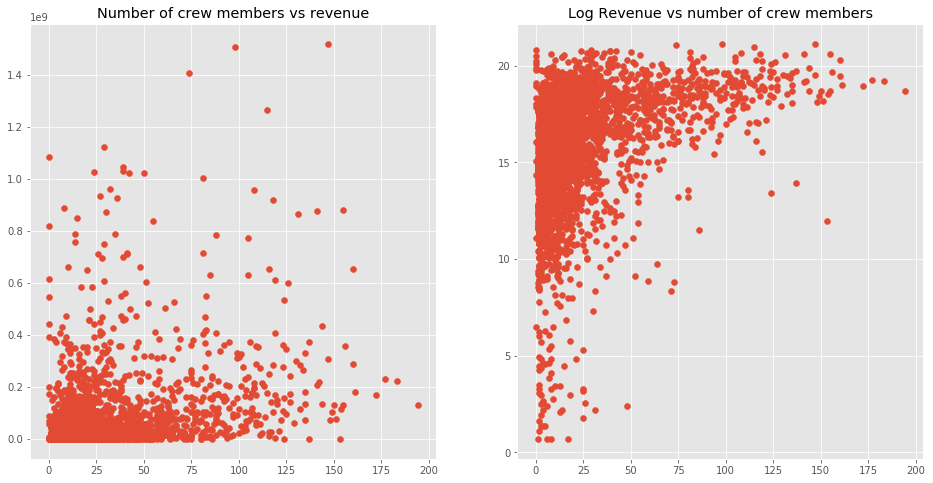

In [107]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_crew'], train['log_revenue'])
plt.title('Log Revenue vs number of crew members');

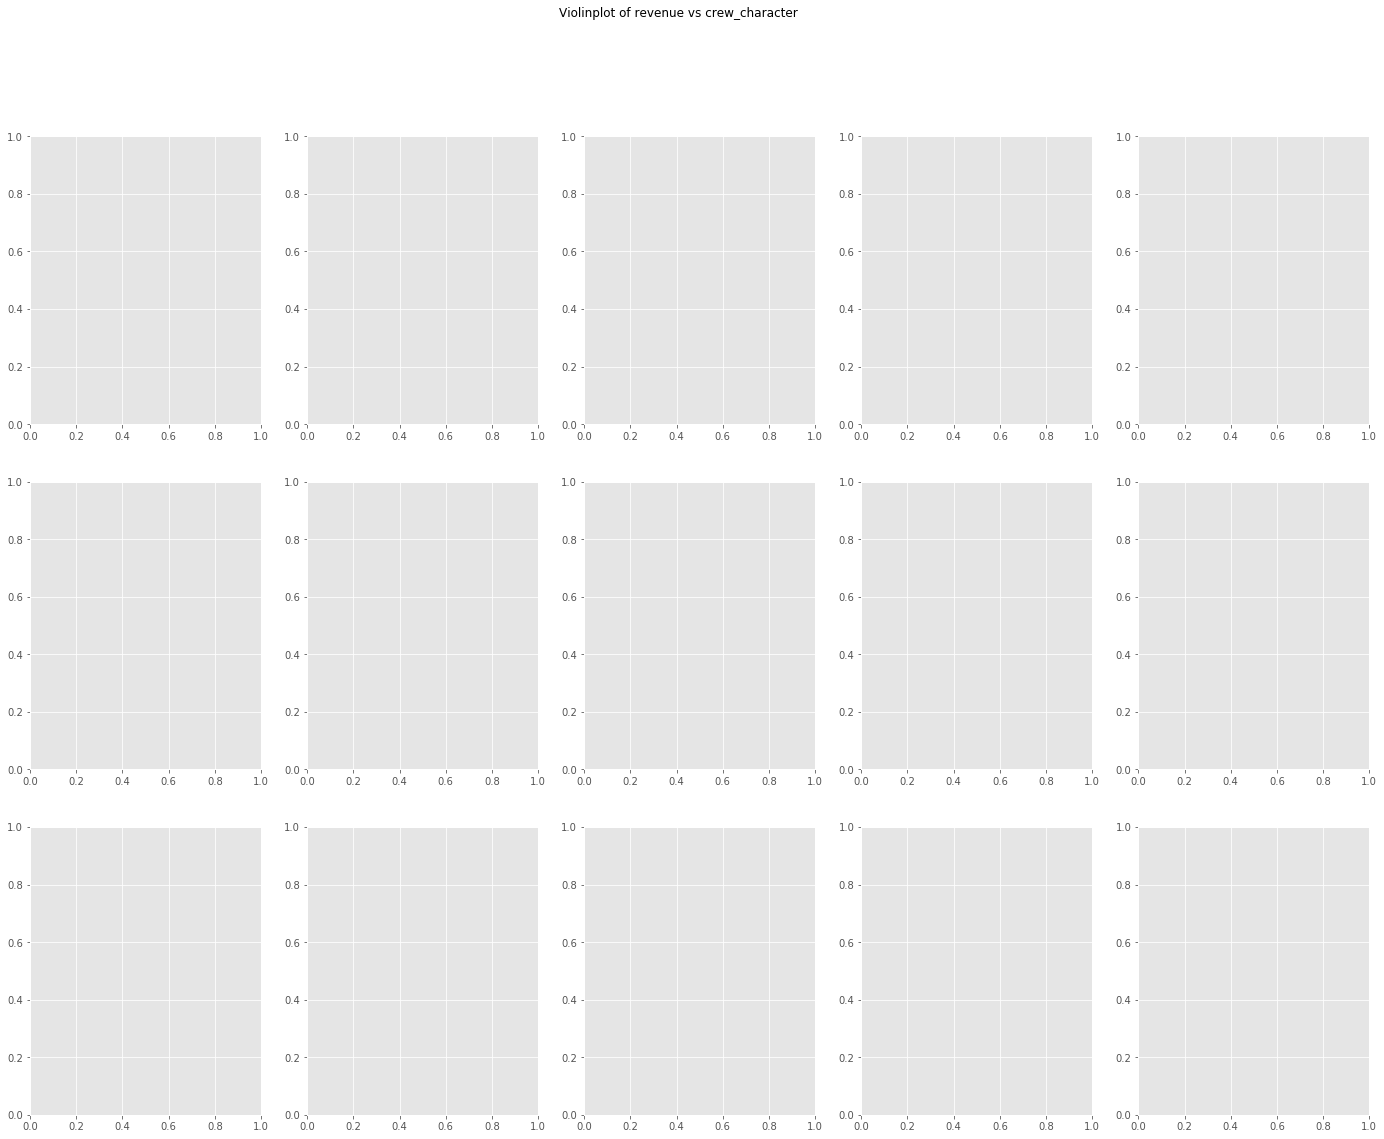

In [108]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_character')
for i, e in enumerate([col for col in train.columns if 'crew_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

不同数量jobs所带来的收入

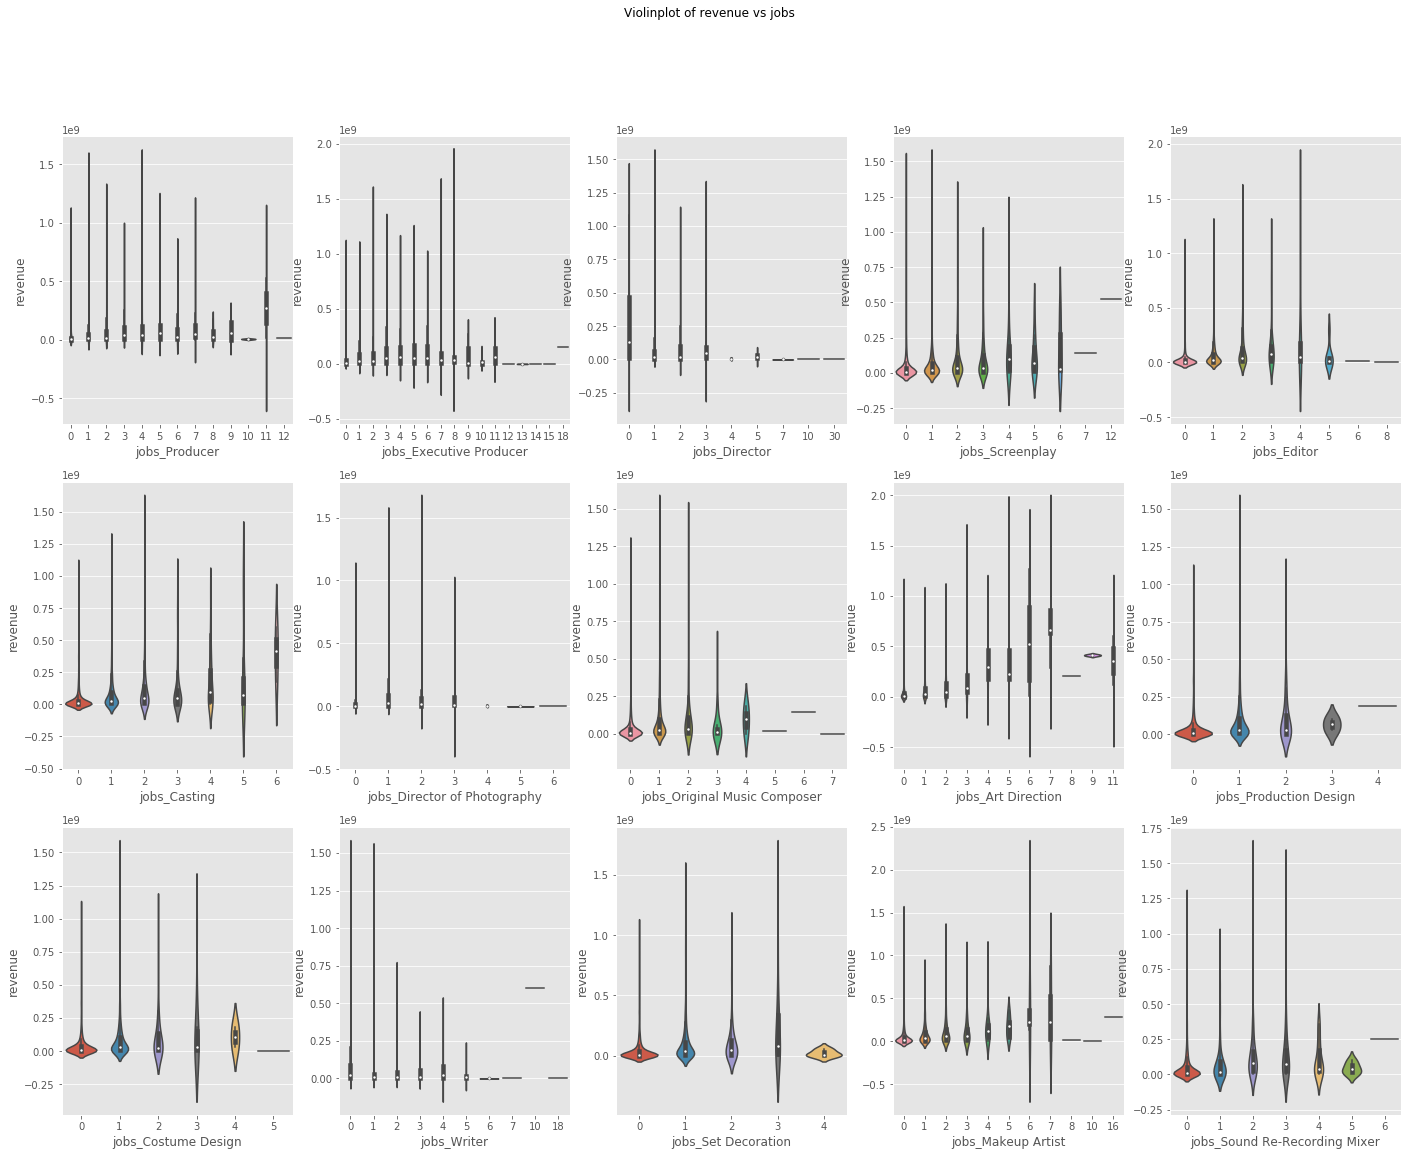

In [109]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="basic_model"></a>
## Modelling and feature generation

建模和特征生成

In [110]:
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [111]:
train.columns

Index(['id', 'budget', 'original_language', 'original_title', 'overview',
       'popularity', 'runtime', 'tagline', 'title', 'revenue',
       ...
       'departments_Lighting', 'departments_Actors', 'log_budget',
       'has_homepage', 'release_date_year', 'release_date_weekday',
       'release_date_month', 'release_date_weekofyear', 'release_date_day',
       'release_date_quarter'],
      dtype='object', length=236)

去除重复数据

In [112]:
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

language_
cast_character_


In [113]:
train[['original_language', 'collection_name', 'all_genres']]

original_language                  collection_name  \
0                   en  Hot Tub Time Machine Collection   
1                   en  The Princess Diaries Collection   
2                   en                                0   
3                   hi                                0   
4                   ko                                0   
5                   en                                0   
6                   en                                0   
7                   en                                0   
8                   en            The Muppet Collection   
9                   en                                0   
10                  en                 Rocky Collection   
11                  en  Revenge of the Nerds Collection   
12                  en                                0   
13                  en          Chili Palmer Collection   
14                  en                                0   
15                  sr                                0   
16                  en                                0   
17                  en                                0   
18                  en                                0   
19                  en       The Transporter Collection   
20                  en                                0   
21                  en       Friday the 13th Collection   
22                  en                 V/H/S Collection   
23                  en                                0   
24                  en                                0   
25                  en                                0   
26                  en                                0   
27                  en                                0   
28                  en                                0   
29                  en                                0   
...                ...                              ...   
2970                en                                0   
2971                en                                0   
2972                cn                                0   
2973                en                                0   
2974                en     Alone in the Dark Collection   
2975                en                                0   
2976                en                                0   
2977                en                                0   
2978                en                                0   
2979                en                                0   
2980                ml                                0   
2981                en                                0   
2982                en                                0   
2983                en                                0   
2984                en              S.W.A.T. Collection   
2985                en                                0   
2986                en                                0   
2987                en                                0   
2988                fa                                0   
2989                en                                0   
2990                en                                0   
2991                en   Save The Last Dance Collection   
2992                en                                0   
2993                en                                0   
2994                en                                0   
2995                en                                0   
2996                sv                                0   
2997                en                                0   
2998                en                                0   
2999                en                                0   

                                           all_genres  
0                                              Comedy  
1                         Comedy Drama Family Romance  
2                                               Drama  
3                                      Drama Thriller  
4                                     Action Thriller  
5         

In [114]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

In [115]:
train[['original_language', 'collection_name', 'all_genres']].head()

original_language  collection_name  all_genres
0                 10              282         480
1                 10              641         516
2                 10                1         658
3                 16                1         742
4                 24                1         295

In [116]:
train_texts = train[['title', 'tagline', 'overview', 'original_title']]
test_texts = test[['title', 'tagline', 'overview', 'original_title']]

In [117]:
train.isnull().any()[train.isnull().any().values==True]

overview    True
runtime     True
tagline     True
dtype: bool

In [118]:
train_texts.head()

title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                            overview  \
0  When Lou, who has become the "father of the In...   
1  Mia Thermopolis is now a college graduate and ...   
2  Under the direction of a ruthless instructor, ...   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...   
4  Marine Boy is the story of a former national s...   

                             original_title  
0                    Hot Tub Time Machine 2  
1  The Princess Diaries 2: Royal Engagement  
2                                  Whiplash  
3                                   Kahaani  
4                                      마린보이

In [119]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

In [120]:
train.loc[train['id'] == 16,'revenue']

15    198
Name: revenue, dtype: int64

In [121]:
train.loc[train['id'] == 16,'revenue']

15    198
Name: revenue, dtype: int64

In [122]:
train.loc[train['id'] == 1542,'budget']

1541    750000
Name: budget, dtype: int64

In [123]:
# data fixes from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [124]:
X = train.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])
X_test = test.drop(['id'], axis=1)

In [125]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.32493	valid_1's rmse: 1.78913
[2000]	training's rmse: 1.02662	valid_1's rmse: 1.75714
Early stopping, best iteration is:
[2210]	training's rmse: 0.977072	valid_1's rmse: 1.7553


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [127]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

In [128]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [129]:
X.head()

budget  original_language  popularity  runtime  collection_name  \
0  14000000                 10    6.575393     93.0              282   
1  40000000                 10    8.248895    113.0              641   
2   3300000                 10   64.299990    105.0                1   
3   1200000                 16    3.174936    122.0                1   
4         0                 24    1.148070    118.0                1   

   has_collection  num_genres  all_genres  genre_Drama  genre_Comedy  \
0               1           1         480            0             1   
1               1           4         516            1             1   
2               0           1         658            1             0   
3               0           2         742            1             0   
4               0           2         295            0             0   

   genre_Thriller  genre_Action  genre_Romance  genre_Crime  genre_Adventure  \
0               0             0              0            0                0   
1               0             0              1            0                0   
2               0             0              0            0                0   
3               1             0              0            0                0   
4               1             1              0            0                0   

   genre_Horror  genre_Science Fiction  genre_Family  genre_Fantasy  \
0             0                      0             0              0   
1             0                      0             1              0   
2             0                      0             0              0   
3             0                      0             0              0   
4             0                      0             0              0   

   genre_Mystery  genre_Animation  genre_History  genre_Music  num_companies  \
0              0                0              0            0              3   
1              0                0              0            0              1   
2              0                0              0            0              3   
3              0                0              0            0              0   
4              0                0              0            0              0   

   production_company_Warner Bros.  production_company_Universal Pictures  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   
3                                0                                      0   
4                                0                                      0   

   production_company_Paramount Pictures  \
0                                      1   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   production_company_Twentieth Century Fox Film Corporation  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   production_company_Columbia Pictures  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   production_company_Metro-Goldwyn-Mayer (MGM)  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   production_company_New Line Cinema  production_company_Touchstone Pi

In [130]:
X['runtime']=X['runtime'].fillna(X['runtime'].mode()[0])

In [131]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            # .values 相当于直接将 df 转为 ndarray
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            '''
            XGBoost可以加载多种数据格式的训练数据：　　
            libsvm 格式的文本数据；
            Numpy 的二维数组；
            XGBoost 的二进制的缓存文件。加载的数据存储在对象 DMatrix 中。
            '''
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            # dtrain（DMatrix) 要训练的数据。evals验证集，verbose_eval=500 每500个阶段打印验证集上的评估度量(evals必须要有验证集)
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            # ntree_limit（int） - 限制预测中的树数; 默认为best_ntree_limit（如果已定义）（即已经过早期停止训练），否则为0（使用所有树）。
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Fri Aug 23 09:58:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.1808	valid_1's rmse: 1.83006
Early stopping, best iteration is:
[1014]	training's rmse: 1.17615	valid_1's rmse: 1.82897
Fold 1 started at Fri Aug 23 09:58:16 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.21035	valid_1's rmse: 1.83156
Early stopping, best iteration is:
[1003]	training's rmse: 1.2088	valid_1's rmse: 1.83136
Fold 2 started at Fri Aug 23 09:58:18 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.22372	valid_1's rmse: 1.70256
[2000]	training's rmse: 0.918573	valid_1's rmse: 1.68
Early stopping, best iteration is:
[2375]	training's rmse: 0.831531	valid_1's rmse: 1.67536
Fold 3 started at Fri Aug 23 09:58:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.2041	valid_1's rmse: 1.8626
Early stopping, best iterati

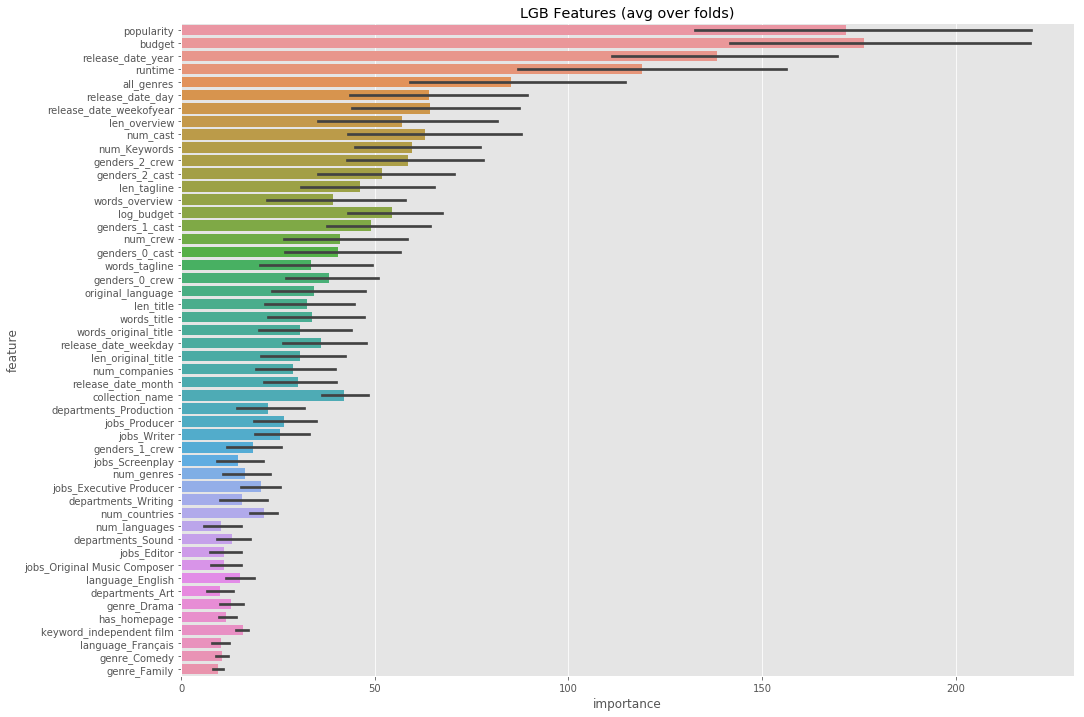

In [132]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="oof"></a>
### OOF features based on texts

   
__TfidfVectorizer参数介绍：__
    
*    __sublinear_tf：__ boolean， optional

    应用线性缩放TF，例如，使用1+log(tf)覆盖tf


*    __ngram_range(min,max)：__ tuple(min_n, max_n)
        
    是指将text分成min，min+1，min+2,.........max 个不同的词组
    
    比如'Python is useful'中ngram_range(1,3)之后可得到'Python'  'is'  'useful'  'Python is'  'is useful' 和'Python is               useful'如果是ngram_range (1,1) 则只能得到单个单词'Python'  'is'和'useful'


*    __token_pattern：__ string
        
    正则表达式显示了”token“的构成，仅当analyzer == ‘word’时才被使用。两个或多个字母数字字符的正则表达式（标点符号完全被忽略，始终被视为一个标记分隔符）。


*    __min_df：__ float in range [0.0, 1.0] or int, optional, 1.0 by default
        
    当构建词汇表时，严格忽略高于给出阈值的文档频率的词条，语料指定的停用词。如果是浮点值，该参数代表文档的比例，整型绝对计数值，如果词汇表不为None，此参数被忽略。


*    __analyzer：__ string，{'word', 'char'} or callable
        
    定义特征为词（word）或n-gram字符，如果传递给它的调用被用于抽取未处理输入源文件的特征序列

In [133]:
for col in train_texts.columns:
    
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(test_texts[col].fillna(''))
    model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
    oof_text, prediction_text = train_model(train_col_text, test_col_text, y, params=None, model_type='sklearn', model=model)
    
    X[col + '_oof'] = oof_text
    X_test[col + '_oof'] = prediction_text

Fold 0 started at Fri Aug 23 09:58:45 2019
Fold 1 started at Fri Aug 23 09:58:45 2019
Fold 2 started at Fri Aug 23 09:58:46 2019
Fold 3 started at Fri Aug 23 09:58:46 2019
Fold 4 started at Fri Aug 23 09:58:47 2019
Fold 5 started at Fri Aug 23 09:58:47 2019
Fold 6 started at Fri Aug 23 09:58:48 2019
Fold 7 started at Fri Aug 23 09:58:48 2019
Fold 8 started at Fri Aug 23 09:58:48 2019
Fold 9 started at Fri Aug 23 09:58:49 2019
CV mean score: 2.9692, std: 0.2116.
Fold 0 started at Fri Aug 23 09:58:50 2019
Fold 1 started at Fri Aug 23 09:58:50 2019
Fold 2 started at Fri Aug 23 09:58:51 2019
Fold 3 started at Fri Aug 23 09:58:51 2019
Fold 4 started at Fri Aug 23 09:58:52 2019
Fold 5 started at Fri Aug 23 09:58:53 2019
Fold 6 started at Fri Aug 23 09:58:53 2019
Fold 7 started at Fri Aug 23 09:58:54 2019
Fold 8 started at Fri Aug 23 09:58:54 2019
Fold 9 started at Fri Aug 23 09:58:55 2019
CV mean score: 2.8814, std: 0.1759.
Fold 0 started at Fri Aug 23 09:58:58 2019
Fold 1 started at Fri Aug

<a id="add_feat"></a>
### Additional feature generation

In [134]:
X.head()

budget  original_language  popularity  runtime  collection_name  \
0  14000000                 10    6.575393     93.0              282   
1  40000000                 10    8.248895    113.0              641   
2   3300000                 10   64.299990    105.0                1   
3   1200000                 16    3.174936    122.0                1   
4         0                 24    1.148070    118.0                1   

   has_collection  num_genres  all_genres  genre_Drama  genre_Comedy  \
0               1           1         480            0             1   
1               1           4         516            1             1   
2               0           1         658            1             0   
3               0           2         742            1             0   
4               0           2         295            0             0   

   genre_Thriller  genre_Action  genre_Romance  genre_Crime  genre_Adventure  \
0               0             0              0            0                0   
1               0             0              1            0                0   
2               0             0              0            0                0   
3               1             0              0            0                0   
4               1             1              0            0                0   

   genre_Horror  genre_Science Fiction  genre_Family  genre_Fantasy  \
0             0                      0             0              0   
1             0                      0             1              0   
2             0                      0             0              0   
3             0                      0             0              0   
4             0                      0             0              0   

   genre_Mystery  genre_Animation  genre_History  genre_Music  num_companies  \
0              0                0              0            0              3   
1              0                0              0            0              1   
2              0                0              0            0              3   
3              0                0              0            0              0   
4              0                0              0            0              0   

   production_company_Warner Bros.  production_company_Universal Pictures  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   
3                                0                                      0   
4                                0                                      0   

   production_company_Paramount Pictures  \
0                                      1   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   production_company_Twentieth Century Fox Film Corporation  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   production_company_Columbia Pictures  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   production_company_Metro-Goldwyn-Mayer (MGM)  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   production_company_New Line Cinema  production_company_Touchstone Pi

In [135]:
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    # some features from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']
    
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
        
    return df

In [136]:
X = new_features(X)
X_test = new_features(X_test)

Fold 0 started at Fri Aug 23 09:59:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.13698	valid_1's rmse: 1.8145
[2000]	training's rmse: 0.812082	valid_1's rmse: 1.79996
Early stopping, best iteration is:
[1964]	training's rmse: 0.821025	valid_1's rmse: 1.7995
Fold 1 started at Fri Aug 23 09:59:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.15468	valid_1's rmse: 1.82428
Early stopping, best iteration is:
[902]	training's rmse: 1.19696	valid_1's rmse: 1.82344
Fold 2 started at Fri Aug 23 09:59:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.16697	valid_1's rmse: 1.73965
[2000]	training's rmse: 0.84782	valid_1's rmse: 1.71389
Early stopping, best iteration is:
[2745]	training's rmse: 0.672692	valid_1's rmse: 1.70252
Fold 3 started at Fri Aug 23 09:59:28 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse:

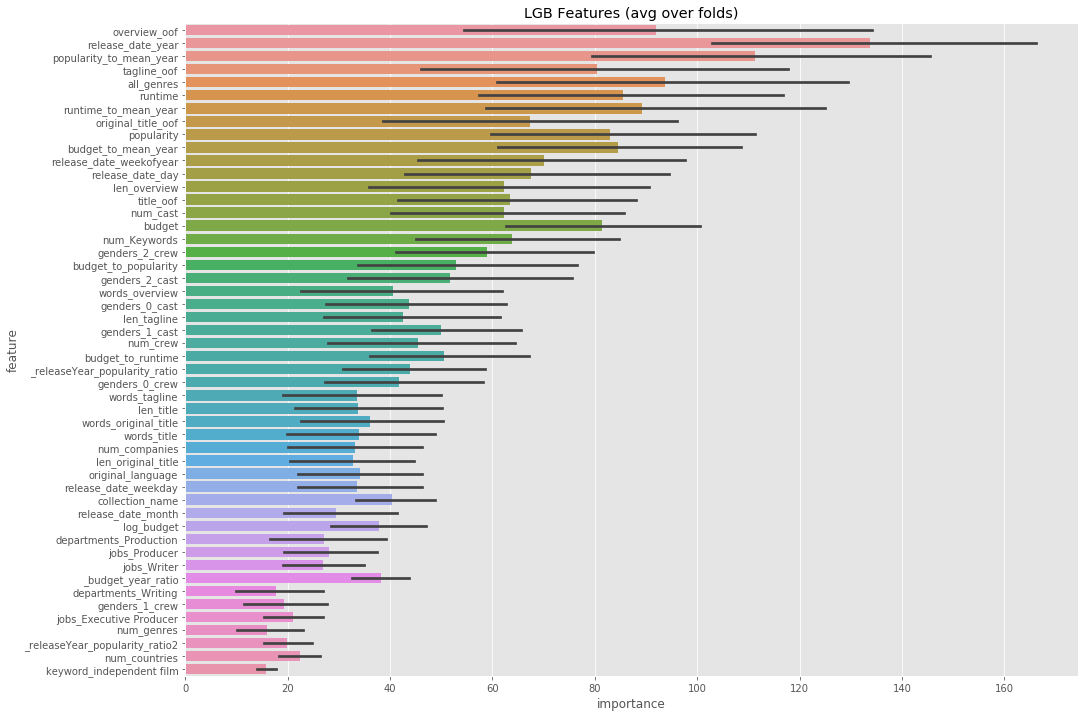

In [137]:
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="imp_feats"></a>
### Important features

Let's have a look at important features using ELI5 and SHAP!

In [138]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.1003	valid_1's rmse: 1.67974
Early stopping, best iteration is:
[904]	training's rmse: 1.14441	valid_1's rmse: 1.67784


We can see that important features native to LGB and top features in ELI5 are mostly similar. This means that our model is quite good at working with these features.

我们可以看到LGB原生的重要特性和ELI5中的顶级特征大致相似。 这意味着我们的模型非常擅长使用这些功能。

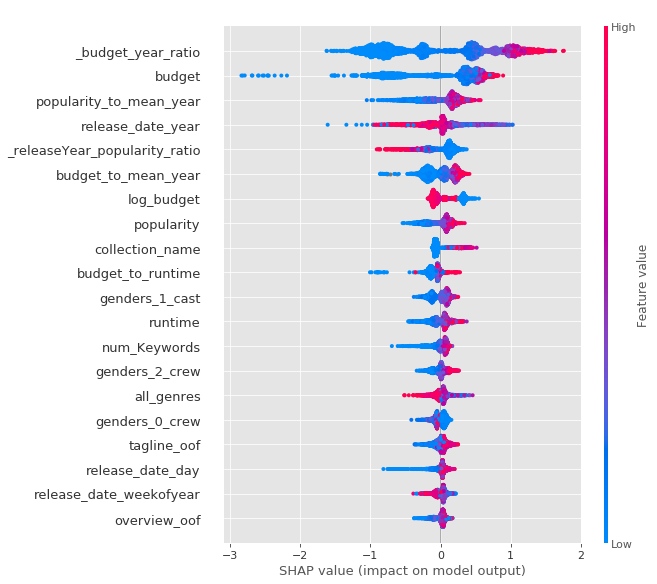

In [139]:
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

SHAP provides more detailed information even if it may be more difficult to understand.

For example low budget has negavite impact on revenue, while high values usually tend to have higher revenue.

SHAP提供更详细的信息，即使它可能更难理解。

例如，低预算对收入产生负面影响，而高价值通常往往会带来更高的收入。

In [141]:
import numpy as np
a=[
    [1,2,3],
   [4,5,6]
  ]
print("列表a如下：")
print(a)
print('\n')

print("增加一维，新维度的下标为0")
c=np.stack(a,axis=0)
print(c)
print('\n')

print("增加一维，新维度的下标为1")
c=np.stack(a,axis=1)
print(c)
print('\n')

print("a 的转置")
c=np.asarray(a).T
print(c)

列表a如下：
[[1, 2, 3], [4, 5, 6]]


增加一维，新维度的下标为0
[[1 2 3]
 [4 5 6]]


增加一维，新维度的下标为1
[[1 4]
 [2 5]
 [3 6]]


a 的转置
[[1 4]
 [2 5]
 [3 6]]


In [142]:
import numpy as np
a=[
    [
        [1,2,3],
   [4,5,6]],
    
    [
        [7,8,9],
   [10,11,12]],
    
    
  ]
print("列表a如下：")
print(a)
print('\n')

print("增加一维，新维度的下标为0")
c=np.stack(a,axis=0)
print(c)
print('\n')

print("增加一维，新维度的下标为1")
c=np.stack(a,axis=1)
print(c)
print('\n')

print("a 的转置")
c=np.asarray(a).T
print(c)

列表a如下：
[[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]]


增加一维，新维度的下标为0
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]


增加一维，新维度的下标为1
[[[ 1  2  3]
  [ 7  8  9]]

 [[ 4  5  6]
  [10 11 12]]]


a 的转置
[[[ 1  7]
  [ 4 10]]

 [[ 2  8]
  [ 5 11]]

 [[ 3  9]
  [ 6 12]]]


In [143]:
a = np.array([[1,2,3,4],[4,5,6,7]])

a[::-1][:2]

array([[4, 5, 6, 7],
       [1, 2, 3, 4]])

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



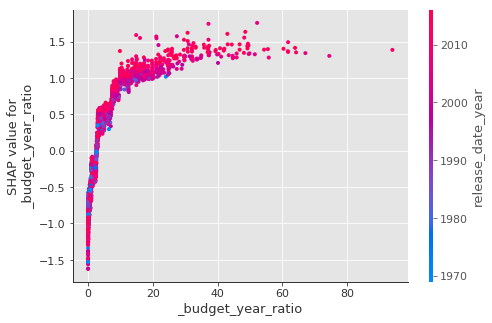

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



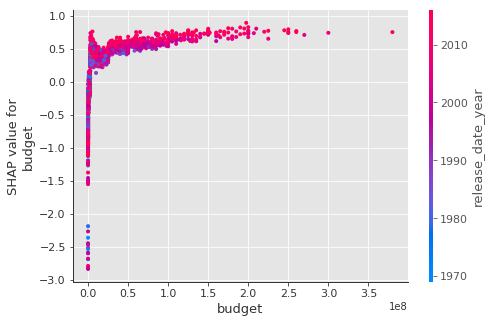

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



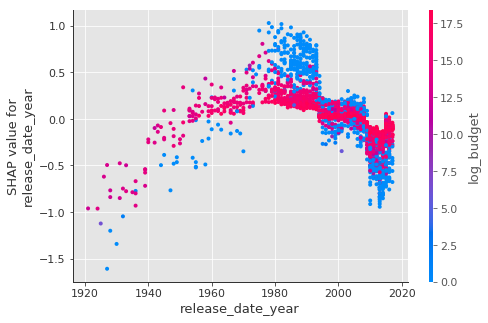

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



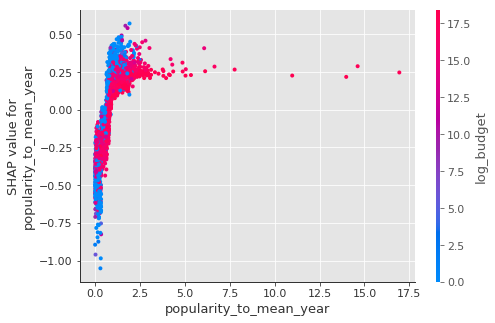

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



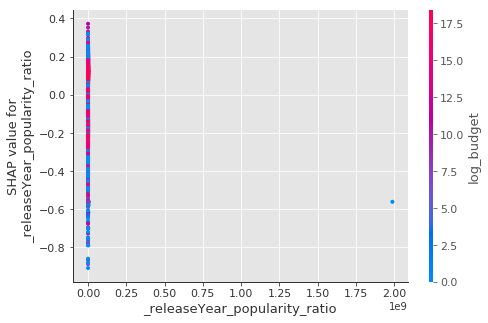

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



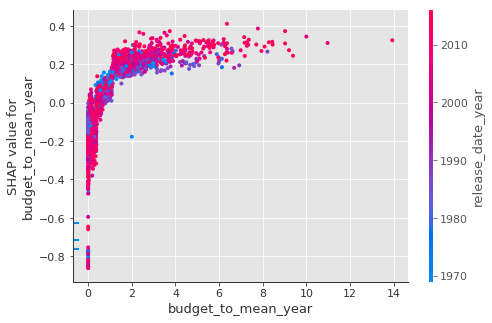

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



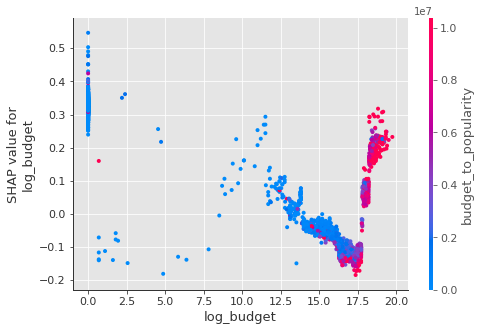

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



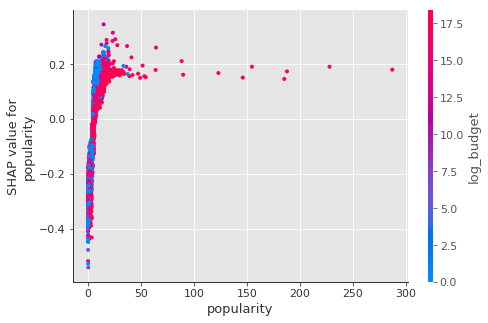

D:\python\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



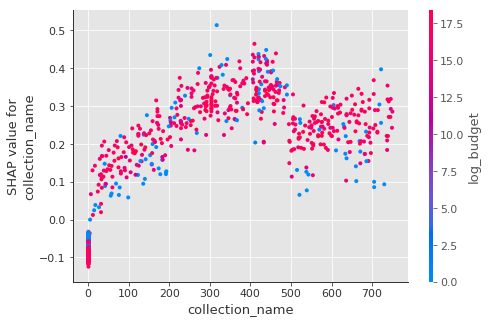

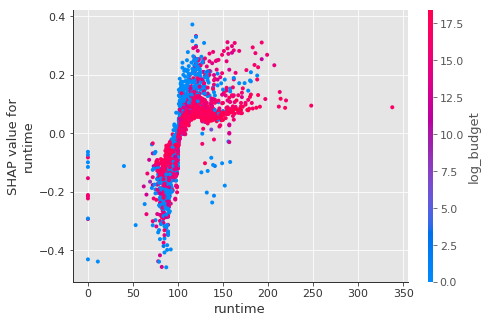

In [144]:
# -1为步长(并且取的是行)，这里步长为-1其实就像将数据上下的顺序翻转，再取前十行，如上面的例子。
top_cols = X_train.columns[np.argsort(shap_values.std(0))[::-1]][:10]
for col in top_cols:
    shap.dependence_plot(col, shap_values, X_train)

Here we can see interactions between important features. There are some interesting things here. For example relationship between release_date_year and log_budget. Up to ~1990 low budget films brought higher revenues, but after 2000 year high budgets tended to be correlated with higher revenues. And in genereal the effect of budget diminished.

Let's create new features as interactions between top important features. Some of them make little sense, but maybe they could improve the model.


在这里，我们可以看到重要功能之间 这里有一些有趣的事情。 例如，release_date_year和log_budget之间的关系。 高达1990年的低预算电影带来了更高的收入，但在2000年之后，高预算往往与更高的收入相关联。 而且在实际情况下，预算的影响减弱了。

让我们创建新功能作为最重要功能之间的交互。 其中一些没有意义，但也许他们可以改进模型。

In [145]:
def top_cols_interaction(df):
    df['budget_to_year'] = df['budget'] / df['release_date_year']
    df['budget_to_mean_year_to_year'] = df['budget_to_mean_year'] / df['release_date_year']
    df['popularity_to_mean_year_to_log_budget'] = df['popularity_to_mean_year'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_year']
    df['genders_1_cast_to_log_budget'] = df['genders_1_cast'] / df['log_budget']
    df['all_genres_to_popularity_to_mean_year'] = df['all_genres'] / df['popularity_to_mean_year']
    df['genders_2_crew_to_budget_to_mean_year'] = df['genders_2_crew'] / df['budget_to_mean_year']
    df['overview_oof_to_genders_2_crew'] = df['overview_oof'] / df['genders_2_crew']
    
    return df

In [146]:
X = top_cols_interaction(X)
X_test = top_cols_interaction(X_test)

In [147]:
X = X.replace([np.inf, -np.inf], 0).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

<a id="ext_feats"></a>
### External features
I'm adding external features from this kernel: https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat by kamalchhirang. All credit for these features goes to him and his kernel.

In [150]:
# trainAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TrainAdditionalFeatures.csv')
# testAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TestAdditionalFeatures.csv')

# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')
# X['imdb_id'] = train['imdb_id']
# X_test['imdb_id'] = test['imdb_id']
# del train, test

# X = pd.merge(X, trainAdditionalFeatures, how='left', on=['imdb_id'])
# X_test = pd.merge(X_test, testAdditionalFeatures, how='left', on=['imdb_id'])

# X = X.drop(['imdb_id'], axis=1)
# X_test = X_test.drop(['imdb_id'], axis=1)

In [151]:
X.head()

budget  original_language  popularity  runtime  collection_name  \
0  14000000                 10    6.575393     93.0              282   
1  40000000                 10    8.248895    113.0              641   
2   3300000                 10   64.299990    105.0                1   
3   1200000                 16    3.174936    122.0                1   
4         0                 24    1.148070    118.0                1   

   has_collection  num_genres  all_genres  genre_Drama  genre_Comedy  \
0               1           1         480            0             1   
1               1           4         516            1             1   
2               0           1         658            1             0   
3               0           2         742            1             0   
4               0           2         295            0             0   

   genre_Thriller  genre_Action  genre_Romance  genre_Crime  genre_Adventure  \
0               0             0              0            0                0   
1               0             0              1            0                0   
2               0             0              0            0                0   
3               1             0              0            0                0   
4               1             1              0            0                0   

   genre_Horror  genre_Science Fiction  genre_Family  genre_Fantasy  \
0             0                      0             0              0   
1             0                      0             1              0   
2             0                      0             0              0   
3             0                      0             0              0   
4             0                      0             0              0   

   genre_Mystery  genre_Animation  genre_History  genre_Music  num_companies  \
0              0                0              0            0              3   
1              0                0              0            0              1   
2              0                0              0            0              3   
3              0                0              0            0              0   
4              0                0              0            0              0   

   production_company_Warner Bros.  production_company_Universal Pictures  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   
3                                0                                      0   
4                                0                                      0   

   production_company_Paramount Pictures  \
0                                      1   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   production_company_Twentieth Century Fox Film Corporation  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   production_company_Columbia Pictures  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   production_company_Metro-Goldwyn-Mayer (MGM)  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   production_company_New Line Cinema  production_company_Touchstone Pi

Fold 0 started at Fri Aug 23 10:12:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.874134	valid_1's rmse: 1.79862
Early stopping, best iteration is:
[1259]	training's rmse: 0.746079	valid_1's rmse: 1.79629
Fold 1 started at Fri Aug 23 10:12:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[745]	training's rmse: 1.03271	valid_1's rmse: 1.88782
Fold 2 started at Fri Aug 23 10:12:49 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.878982	valid_1's rmse: 1.71746
Early stopping, best iteration is:
[1537]	training's rmse: 0.640778	valid_1's rmse: 1.70558
Fold 3 started at Fri Aug 23 10:12:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.867391	valid_1's rmse: 1.88838
Early stopping, best iteration is:
[1037]	training's rmse: 0.847017	valid_1's rmse: 1.88602
Fold 4 started at Fri Aug 23 10:13:05 2

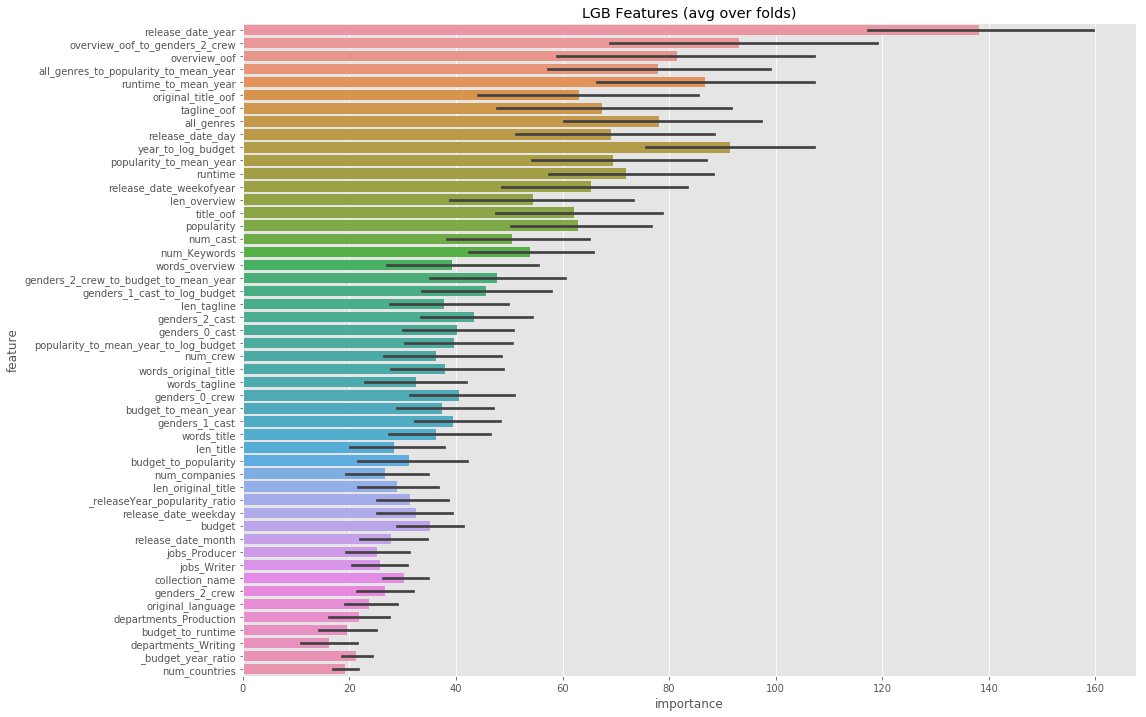

In [152]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

In [156]:
oof_lgb[2]

17.378508050846783

In [153]:
oof_lgb.shape

(3000,)

<a id="blending"></a>
### Blending

In [157]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Fri Aug 23 11:44:42 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5964	valid_data-rmse:15.8993
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.95012	valid_data-rmse:1.81276
[1000]	train-rmse:0.587032	valid_data-rmse:1.78118
[1500]	train-rmse:0.380974	valid_data-rmse:1.77714
Stopping. Best iteration:
[1798]	train-rmse:0.291261	valid_data-rmse:1.776

Fold 1 started at Fri Aug 23 11:45:20 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6274	valid_data-rmse:15.6189
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.939493	valid_data-rmse:1.87113
[1000]	train-rmse:0.591215	valid_data-rmse:1.8493
Stopping. Best iteration:
[1164]	train-rmse:0.514278	valid_data-rmse:1.84524

Fold 2 started at Fri Aug 23 11:45:44 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6147	valid_data-rmse:15.736
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.946799	valid_data-rmse:1.70769
[1000]	train-rmse:0.5868	valid_data-rmse:1.65419
[1500]	train-rmse:0.379817	valid_data-rmse:1.6412
Stopping. Best iteration:
[1491]	train-rmse:0.382801	valid_data-rmse:1.64119

Fold 3 started at Fri Aug 23 11:46:14 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.648	valid_data-rmse:15.4321
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.936434	valid_data-rmse:1.85096
[1000]	train-rmse:0.584136	valid_data-rmse:1.82993
[1500]	train-rmse:0.375026	valid_data-rmse:1.8292
Stopping. Best iteration:
[1345]	train-rmse:0.431204	valid_data-rmse:1.82779

Fold 4 started at Fri Aug 23 11:46:42 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6207	valid_data-rmse:15.6882
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.951705	valid_data-rmse:1.74247
[1000]	train-rmse:0.595423	valid_data-rmse:1.70259
[1500]	train-rmse:0.381121	valid_data-rmse:1.69928
Stopping. Best iteration:
[1465]	train-rmse:0.392844	valid_data-rmse:1.69871

Fold 5 started at Fri Aug 23 11:47:23 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6339	valid_data-rmse:15.5616
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.970856	valid_data-rmse:1.75903
[1000]	train-rmse:0.612024	valid_data-rmse:1.7386
Stopping. Best iteration:
[1131]	train-rmse:0.543376	valid_data-rmse:1.73658

Fold 6 started at Fri Aug 23 11:47:53 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6192	valid_data-rmse:15.6936
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.916311	valid_data-rmse:2.19409
[1000]	train-rmse:0.570101	valid_data-rmse:2.18747
Stopping. Best iteration:
[832]	train-rmse:0.660335	valid_data-rmse:2.18598

Fold 7 started at Fri Aug 23 11:48:16 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6546	valid_data-rmse:15.3719
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.942915	valid_data-rmse:2.17103
[1000]	train-rmse:0.582451	valid_data-rmse:2.16283
[1500]	train-rmse:0.378258	valid_data-rmse:2.15434
[2000]	train-rmse:0.246697	valid_data-rmse:2.15098
Stopping. Best iteration:
[1996]	train-rmse:0.247443	valid_data-rmse:2.15086

Fold 8 started at Fri Aug 23 11:49:04 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6405	valid_data-rmse:15.507
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.960727	valid_data-rmse:2.0173
Stopping. Best iteration:
[715]	train-rmse:0.777874	valid_data-rmse:2.01493

Fold 9 started at Fri Aug 23 11:49:23 2019


D:\python\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6114	valid_data-rmse:15.7603
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.942461	valid_data-rmse:1.91346
[1000]	train-rmse:0.581946	valid_data-rmse:1.89445
Stopping. Best iteration:
[1149]	train-rmse:0.509716	valid_data-rmse:1.89157

CV mean score: 1.8769, std: 0.1762.


In [159]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(X, X_test, y, params=cat_params, model_type='cat')

Fold 0 started at Fri Aug 23 11:50:19 2019
Fold 1 started at Fri Aug 23 12:00:15 2019
Fold 2 started at Fri Aug 23 12:02:55 2019
Fold 3 started at Fri Aug 23 12:16:13 2019
Fold 4 started at Fri Aug 23 12:27:14 2019
Fold 5 started at Fri Aug 23 12:38:20 2019
Fold 6 started at Fri Aug 23 12:49:52 2019
Fold 7 started at Fri Aug 23 12:56:28 2019
Fold 8 started at Fri Aug 23 13:05:56 2019
Fold 9 started at Fri Aug 23 13:13:26 2019
CV mean score: 1.9139, std: 0.1848.


In [160]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, prediction_lgb_1 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Fri Aug 23 13:18:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.28211	valid_1's rmse: 1.80063
Early stopping, best iteration is:
[1792]	training's rmse: 1.02235	valid_1's rmse: 1.79133
Fold 1 started at Fri Aug 23 13:18:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[790]	training's rmse: 1.38005	valid_1's rmse: 1.91374
Fold 2 started at Fri Aug 23 13:18:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.2872	valid_1's rmse: 1.72248
[2000]	training's rmse: 0.968502	valid_1's rmse: 1.70995
Early stopping, best iteration is:
[2208]	training's rmse: 0.917957	valid_1's rmse: 1.70762
Fold 3 started at Fri Aug 23 13:18:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.2758	valid_1's rmse: 1.87387
Early stopping, best iteration is:
[1200]	training's rmse: 1.19941	valid_1's rms

In [161]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2, prediction_lgb_2 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Fri Aug 23 13:19:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[433]	training's rmse: 1.11287	valid_1's rmse: 1.79634
Fold 1 started at Fri Aug 23 13:19:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[213]	training's rmse: 1.42226	valid_1's rmse: 1.86996
Fold 2 started at Fri Aug 23 13:19:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[555]	training's rmse: 1.00185	valid_1's rmse: 1.72934
Fold 3 started at Fri Aug 23 13:19:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 1.23551	valid_1's rmse: 1.86714
Fold 4 started at Fri Aug 23 13:19:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[700]	training's rmse: 0.884089	valid_1's rmse: 1.70517
Fold 5 started at F

<a id="stacking"></a>
### Stacking

In [ ]:
# vstack一维数据相当于将 原先shape位置调换，然后增加行数据 如(3000,1)->(1,3000) 5个数据组合 ->(5,3000)
# transpose 二维数据相当于转置
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_cat, prediction_lgb_1, prediction_lgb_2]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

In [ ]:
test_stack.shape()

Fold 0 started at Mon May  6 10:37:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[374]	training's rmse: 1.76586	valid_1's rmse: 1.71628
Fold 1 started at Mon May  6 10:37:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[740]	training's rmse: 1.71308	valid_1's rmse: 1.80835
Fold 2 started at Mon May  6 10:37:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 1.79841	valid_1's rmse: 1.66626
Fold 3 started at Mon May  6 10:37:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[413]	training's rmse: 1.75118	valid_1's rmse: 1.7981
Fold 4 started at Mon May  6 10:37:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[248]	training's rmse: 1.80359	valid_1's rmse: 1.6717
Fold 5 started at Mon 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



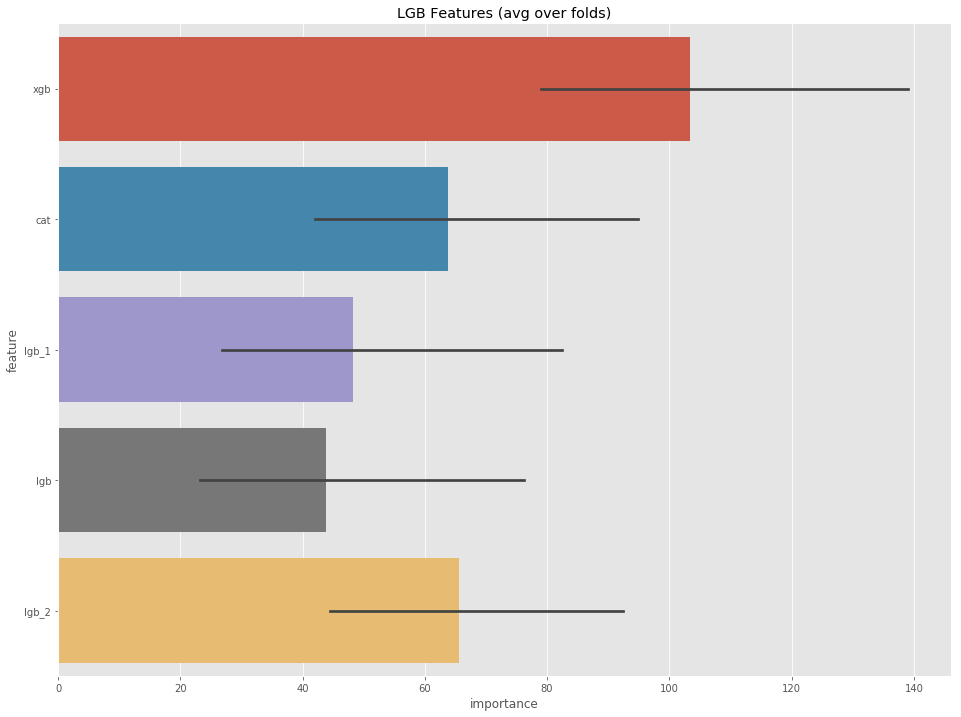

In [122]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack, prediction_lgb_stack, _ = train_model(train_stack, test_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

In [123]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack, prediction_rcv_stack = train_model(train_stack.values, test_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Mon May  6 10:37:17 2019
Fold 1 started at Mon May  6 10:37:17 2019
Fold 2 started at Mon May  6 10:37:18 2019
Fold 3 started at Mon May  6 10:37:18 2019
Fold 4 started at Mon May  6 10:37:18 2019
Fold 5 started at Mon May  6 10:37:18 2019
Fold 6 started at Mon May  6 10:37:18 2019
Fold 7 started at Mon May  6 10:37:18 2019
Fold 8 started at Mon May  6 10:37:18 2019
Fold 9 started at Mon May  6 10:37:19 2019
CV mean score: 1.8074, std: 0.1699.


In [124]:
sub = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
sub['revenue'] = np.expm1(prediction_lgb)
sub.to_csv("lgb.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sub.to_csv("blend.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat) / 3)
sub.to_csv("blend1.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1) / 4)
sub.to_csv("blend2.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1 + prediction_lgb_2) / 5)
sub.to_csv("blend3.csv", index=False)

sub['revenue'] = prediction_lgb_stack
sub.to_csv("stack_lgb.csv", index=False)
sub['revenue'] = prediction_rcv_stack
sub.to_csv("stack_rcv.csv", index=False)